# Inference at high SNR

This notebook is to make sure anyone can do inference and produce the figures

In [1]:
import numpy as np
from astroNN.datasets import H5Loader
from astroNN.models import load_folder

# Load the dataset testing data
loader = H5Loader('_highsnr_test')
loader.load_combined = True  # load individual visits
loader.load_err = False
# load the correct entry with correct order from ApogeeBCNNcensored
loader.target = ['teff', 'logg', 'C', 'C1', 'N', 'O', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'K',
                 'Ca', 'Ti', 'Ti2', 'V', 'Cr', 'Mn', 'Fe','Co', 'Ni']
x, y = loader.load()

# load RA, DEC, SNR entry
RA_visit = loader.load_entry('RA')
DEC_visit = loader.load_entry('DEC')
SNR_visit = loader.load_entry('SNR')

# Load model and do inference
bcnn = load_folder('astroNN_0617_run001')
bcnn.mc_num = 100
pred, pred_err = bcnn.test(x)

Using TensorFlow backend.


Loaded astroNN model, model type: Bayesian Convolutional Neural Network -> ApogeeBCNNCensored
Starting Dropout Variational Inference
Completed Dropout Variational Inference with 100 forward passes, 109.57s elapsed


### Isochrones from http://stev.oapd.inaf.it/cgi-bin/cmd_3.0

**Configuration:**
- PARSEC v1.2S + COLIBRI PR16
- Gaia DR2 + Tycho2 + 2MASS (all Veggamags)
- NBC as described on Chen et al. (2014), based on PHOENIX BT-Settl for Teff<4000 K, and on ATLAS9 ODFNEW otherwise or on
- Aringer et al. (2009) (updated to include new spectra from Aringer et al. (2016)) 
- No dust
- Single isochrone of t = $5.0x10^{9}$ yr, and $[Z/H]$ = $0.25$, $-0.25$, $-0.75$, $-1.75$

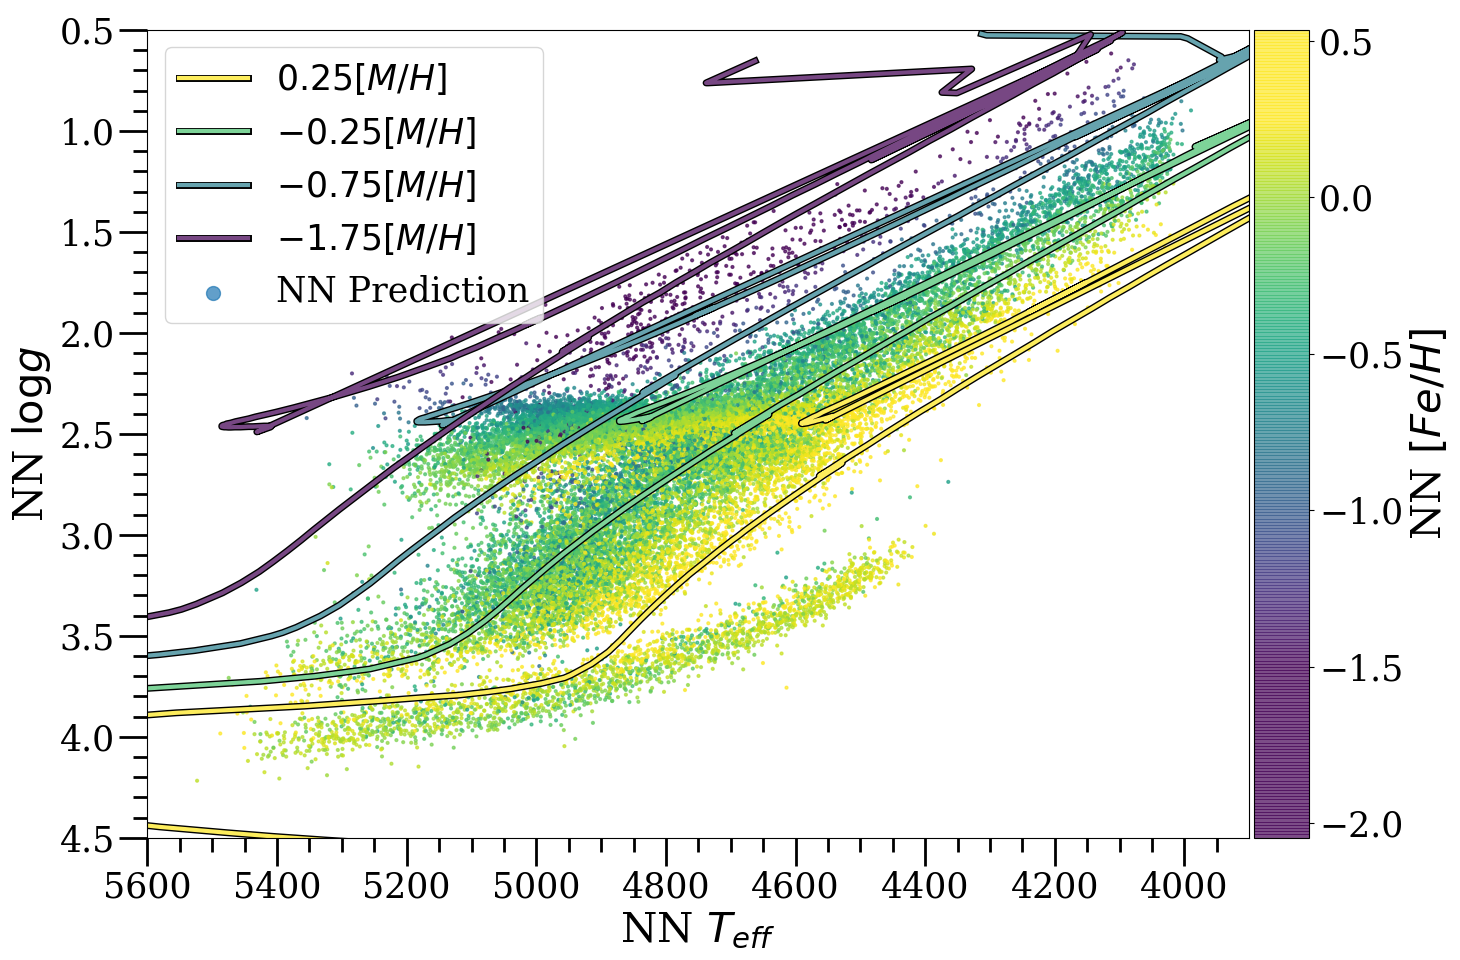

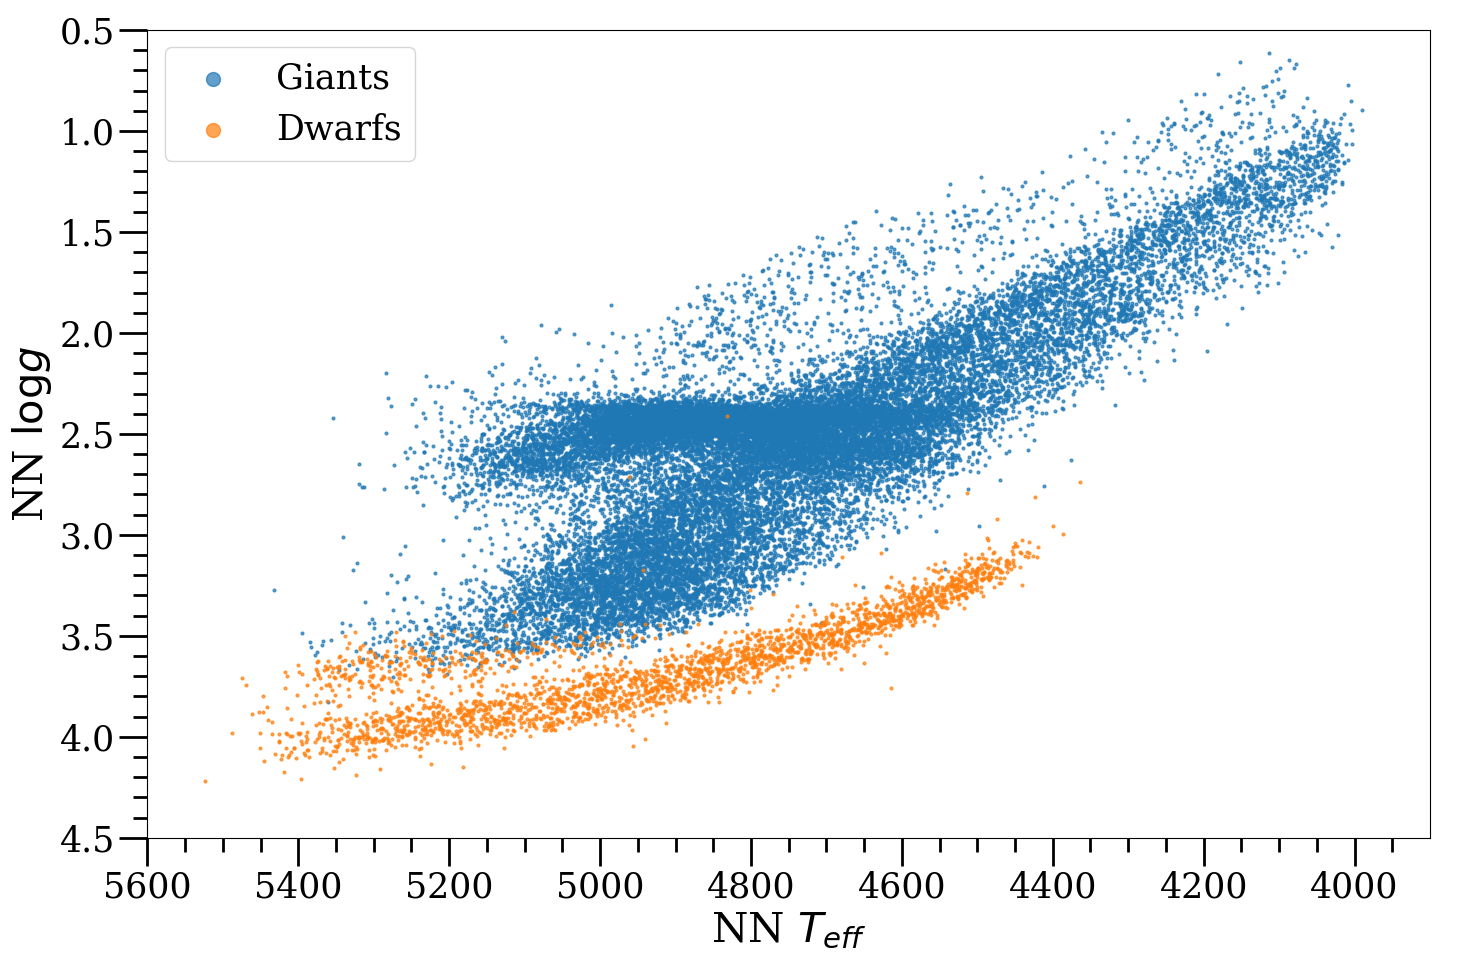

In [7]:
%matplotlib inline
import numpy as np
import pylab as plt
import astropy.io.ascii
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patheffects as pe

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

# load +0.25Z
data_p025 = astropy.io.ascii.read('isochrones\z_p025.dat')
teff_isochrone_p025 = 10 ** data_p025['col6']
logg_isochrone_p025 = data_p025['col7']
good_idx_p025 = [(logg_isochrone_p025 > 0.5) & (teff_isochrone_p025 < 6200)]

# load -0.25Z
data_n025 = astropy.io.ascii.read('isochrones\z_n025.dat')
teff_isochrone_n025 = 10 ** data_n025['col6']
logg_isochrone_n025 = data_n025['col7']
good_idx_n025 = [(logg_isochrone_n025 > 0.5) & (teff_isochrone_n025 < 6200)]

# load -0.75Z
data_n075 = astropy.io.ascii.read('isochrones\z_n075.dat')
teff_isochrone_n075 = 10 ** data_n075['col6']
logg_isochrone_n075 = data_n075['col7']
good_idx_n075 = [(logg_isochrone_n075 > 0.5) & (teff_isochrone_n075 < 6200)]

# load -1.75Z
data_n175 = astropy.io.ascii.read('isochrones\z_n175.dat')
teff_isochrone_n175 = 10 ** data_n175['col6']
logg_isochrone_n175 = data_n175['col7']
good_idx_n175 = [(logg_isochrone_n175 > 0.5) & (teff_isochrone_n175 < 6200)]

fig = plt.figure(figsize=(15,10), dpi=100)
ax = plt.gca()
plt.scatter(pred[:,0], pred[:,1], s=4., c=pred[:,19], label=f'NN Prediction', alpha=0.7)
plt.plot(teff_isochrone_p025[good_idx_p025], logg_isochrone_p025[good_idx_p025], lw=3., c='#fded5d', label=r'$0.25 [M/H]$',
         path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal()])
plt.plot(teff_isochrone_n025[good_idx_n025], logg_isochrone_n025[good_idx_n025], lw=3., c='#7dd398', label=r'$-0.25 [M/H]$',
        path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal()])
plt.plot(teff_isochrone_n075[good_idx_n075], logg_isochrone_n075[good_idx_n075], lw=3., c='#66a3ae', label=r'$-0.75 [M/H]$',
        path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal()])
plt.plot(teff_isochrone_n175[good_idx_n175], logg_isochrone_n175[good_idx_n175], lw=3., c='#774783', label=r'$-1.75 [M/H]$',
        path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal()])
plt.xlabel('NN ' +"$T_{eff}$", fontsize=30)
plt.ylabel('NN '+'$\log{g}$', fontsize=30)
plt.xlim((3900., 5600))
plt.ylim((0.5, 4.5))
plt.legend(loc='best', fontsize=25, markerscale=5)
plt.minorticks_on()
plt.tick_params(labelsize=25, width=2, length=20, which='major')
plt.tick_params(width=2, length=10, which='minor')
ax.invert_xaxis()
ax.invert_yaxis()
#colorbar 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(cax=cax)
cbar.set_clim(vmin=-1.5, vmax=0.25)
cbar.ax.tick_params(labelsize=25)
cbar.set_label("NN "+"$[Fe/H]$", size=30)
            
plt.tight_layout()
plt.savefig('logg_teff_fe_isochrones.png')
plt.show()

# ==================plot giants and dwarfs=========================== #

fig = plt.figure(figsize=(15,10), dpi=100)
ax = plt.gca()
plt.scatter(pred[:,0][y[:, 1]!=-9999.], pred[:,1][y[:, 1]!=-9999.], s=4., label=f'Giants', alpha=0.7)
plt.scatter(pred[:,0][y[:, 1]==-9999.], pred[:,1][y[:, 1]==-9999.], s=4., label=f'Dwarfs', alpha=0.7)
plt.xlabel('NN ' +"$T_{eff}$", fontsize=30)
plt.ylabel('NN '+'$\log{g}$', fontsize=30)
plt.xlim((3900., 5600))
plt.ylim((0.5, 4.5))
plt.legend(loc='best', fontsize=25, markerscale=5)
plt.minorticks_on()
plt.tick_params(labelsize=25, width=2, length=20, which='major')
plt.tick_params(width=2, length=10, which='minor')
ax.invert_xaxis()
ax.invert_yaxis()
plt.tight_layout()
plt.show()

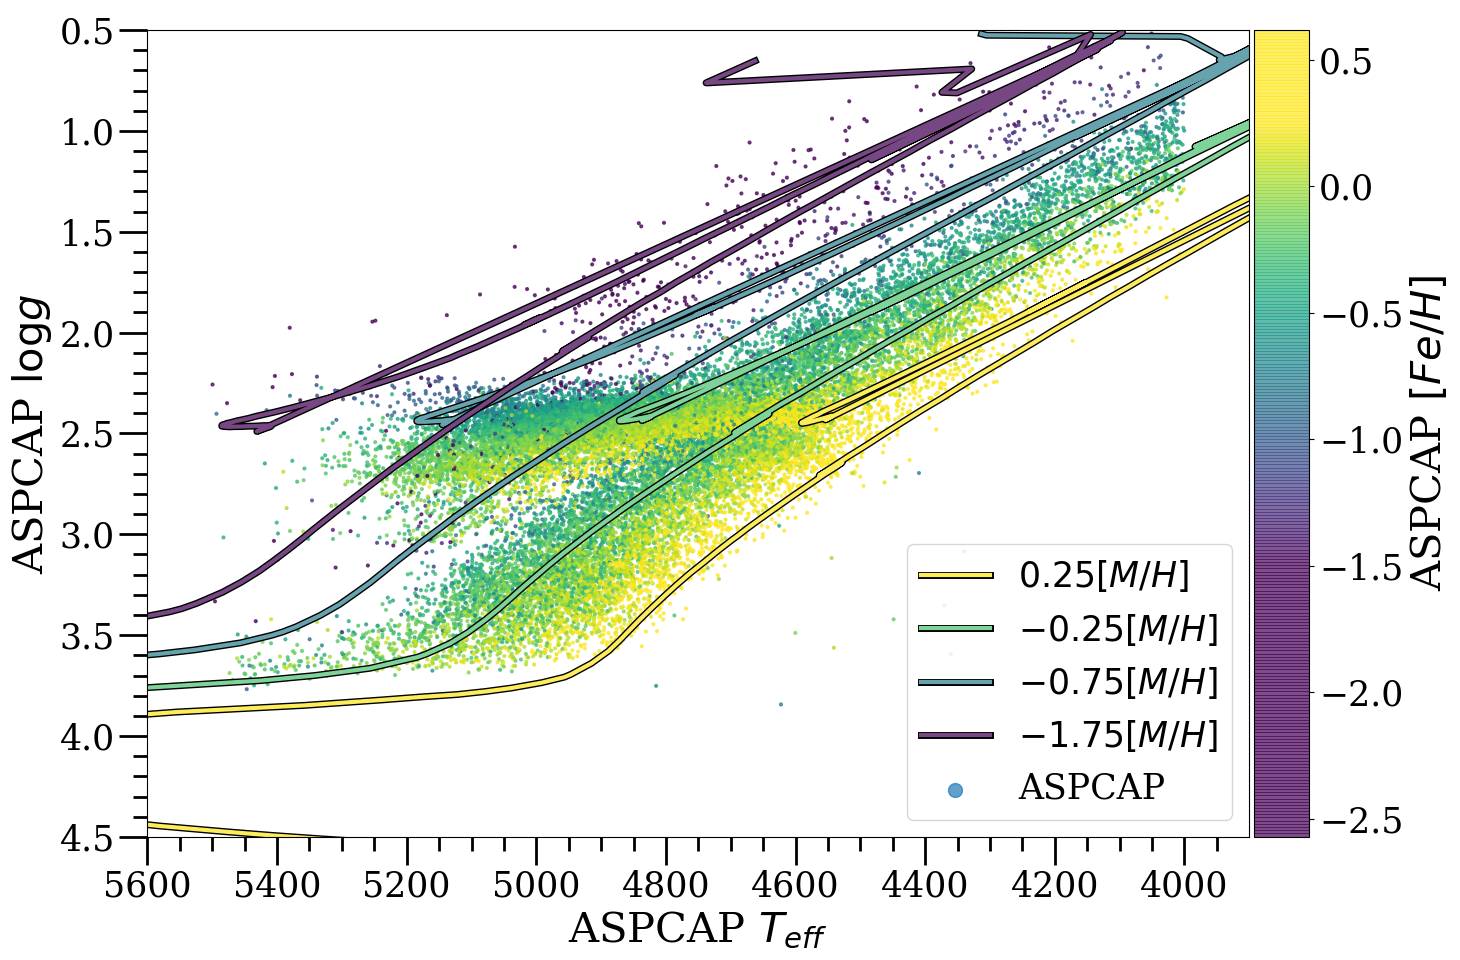

In [8]:
%matplotlib inline
import numpy as np
import pylab as plt
import astropy.io.ascii
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

# load +0.25Z
data_p025 = astropy.io.ascii.read('isochrones\z_p025.dat')
teff_isochrone_p025 = 10 ** data_p025['col6']
logg_isochrone_p025 = data_p025['col7']
good_idx_p025 = [(logg_isochrone_p025 > 0.5) & (teff_isochrone_p025 < 6200)]

# load -0.25Z
data_n025 = astropy.io.ascii.read('isochrones\z_n025.dat')
teff_isochrone_n025 = 10 ** data_n025['col6']
logg_isochrone_n025 = data_n025['col7']
good_idx_n025 = [(logg_isochrone_n025 > 0.5) & (teff_isochrone_n025 < 6200)]

# load -0.75Z
data_n075 = astropy.io.ascii.read('isochrones\z_n075.dat')
teff_isochrone_n075 = 10 ** data_n075['col6']
logg_isochrone_n075 = data_n075['col7']
good_idx_n075 = [(logg_isochrone_n075 > 0.5) & (teff_isochrone_n075 < 6200)]

# load -1.75Z
data_n175 = astropy.io.ascii.read('isochrones\z_n175.dat')
teff_isochrone_n175 = 10 ** data_n175['col6']
logg_isochrone_n175 = data_n175['col7']
good_idx_n175 = [(logg_isochrone_n175 > 0.5) & (teff_isochrone_n175 < 6200)]

fig = plt.figure(figsize=(15,10), dpi=100)
ax = plt.gca()
plt.scatter(y[:,0][y[:,19] != -9999.], y[:,1][y[:,19] != -9999.], s=4., c=y[:,19][y[:,19] != -9999.], label=f'ASPCAP', alpha=0.7)
plt.plot(teff_isochrone_p025[good_idx_p025], logg_isochrone_p025[good_idx_p025], lw=3., c='#fded5d', label=r'$0.25 [M/H]$',
         path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal()])
plt.plot(teff_isochrone_n025[good_idx_n025], logg_isochrone_n025[good_idx_n025], lw=3., c='#7dd398', label=r'$-0.25 [M/H]$',
        path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal()])
plt.plot(teff_isochrone_n075[good_idx_n075], logg_isochrone_n075[good_idx_n075], lw=3., c='#66a3ae', label=r'$-0.75 [M/H]$',
        path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal()])
plt.plot(teff_isochrone_n175[good_idx_n175], logg_isochrone_n175[good_idx_n175], lw=3., c='#774783', label=r'$-1.75 [M/H]$',
        path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal()])
plt.xlabel('ASPCAP ' +"$T_{eff}$", fontsize=30)
plt.ylabel('ASPCAP '+'$\log{g}$', fontsize=30)
plt.xlim((3900., 5600))
plt.ylim((0.5, 4.5))
plt.legend(loc='best', fontsize=25, markerscale=5)
plt.minorticks_on()
plt.tick_params(labelsize=25, width=2, length=20, which='major')
plt.tick_params(width=2, length=10, which='minor')
ax.invert_xaxis()
ax.invert_yaxis()
#colorbar 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(cax=cax)
cbar.set_clim(vmin=-1.5, vmax=0.25)
cbar.ax.tick_params(labelsize=25)
cbar.set_label("ASPCAP "+"$[Fe/H]$", size=30)
            
plt.tight_layout()
# plt.savefig('logg_teff_fe_isochrones.png')
plt.show()

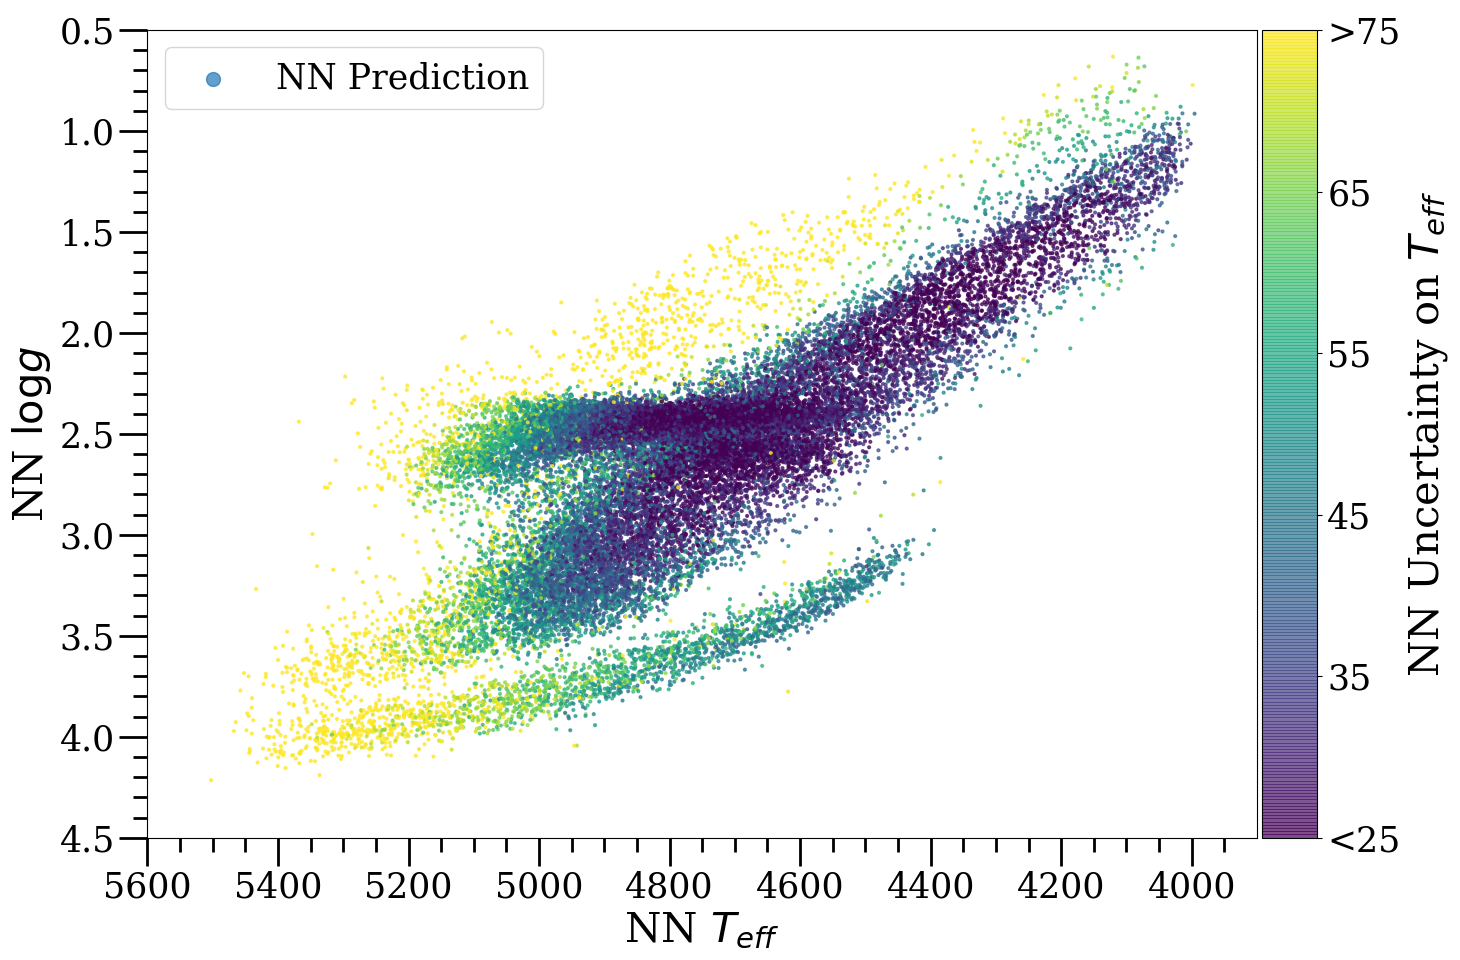

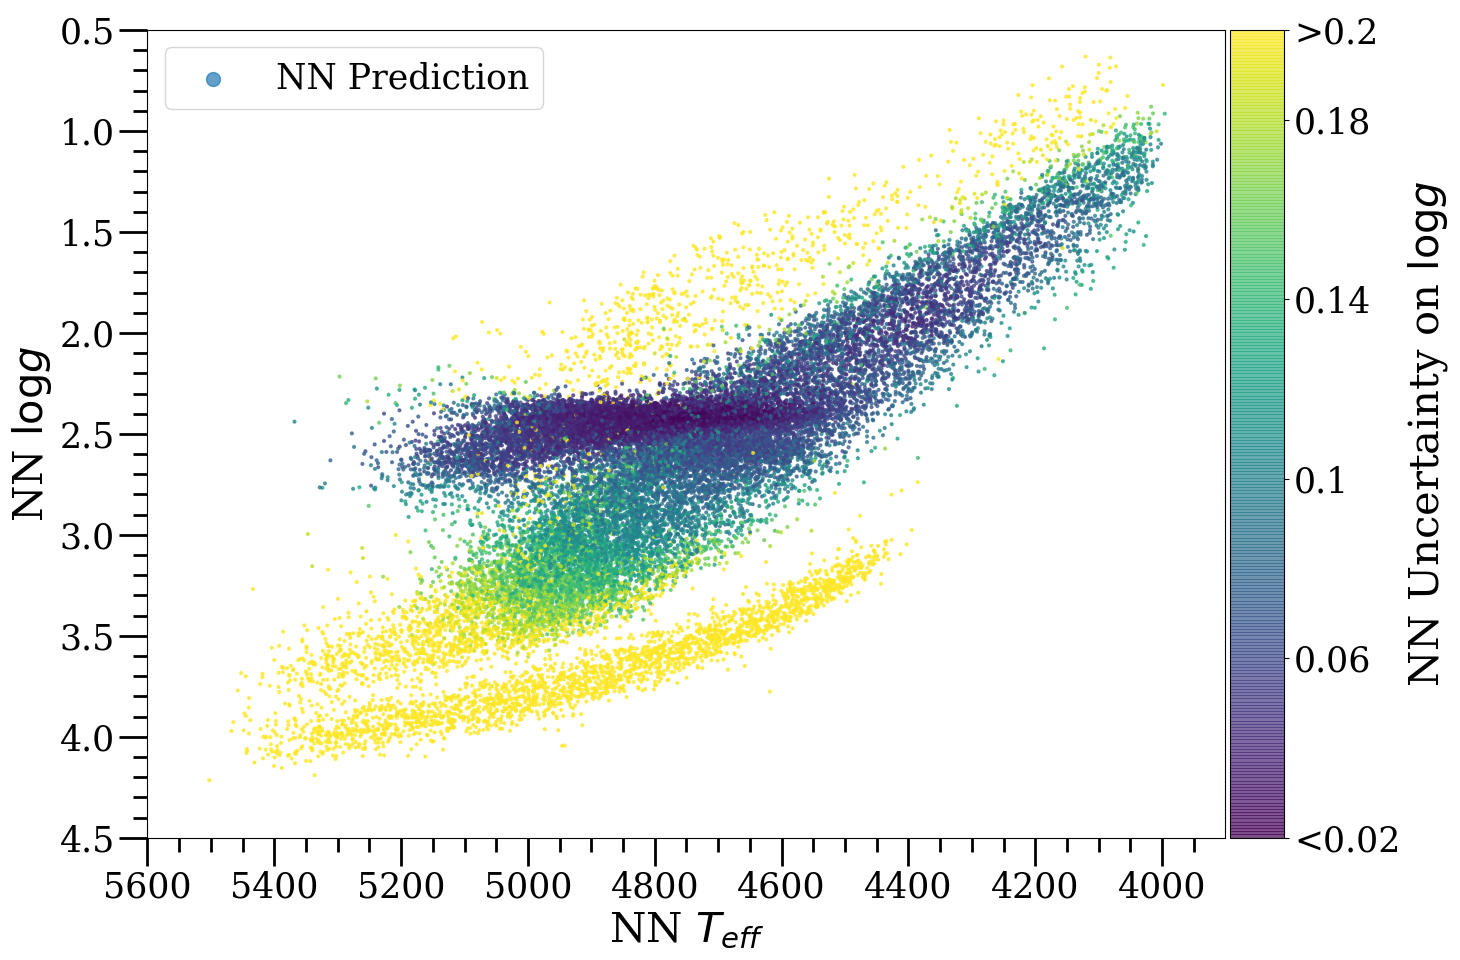

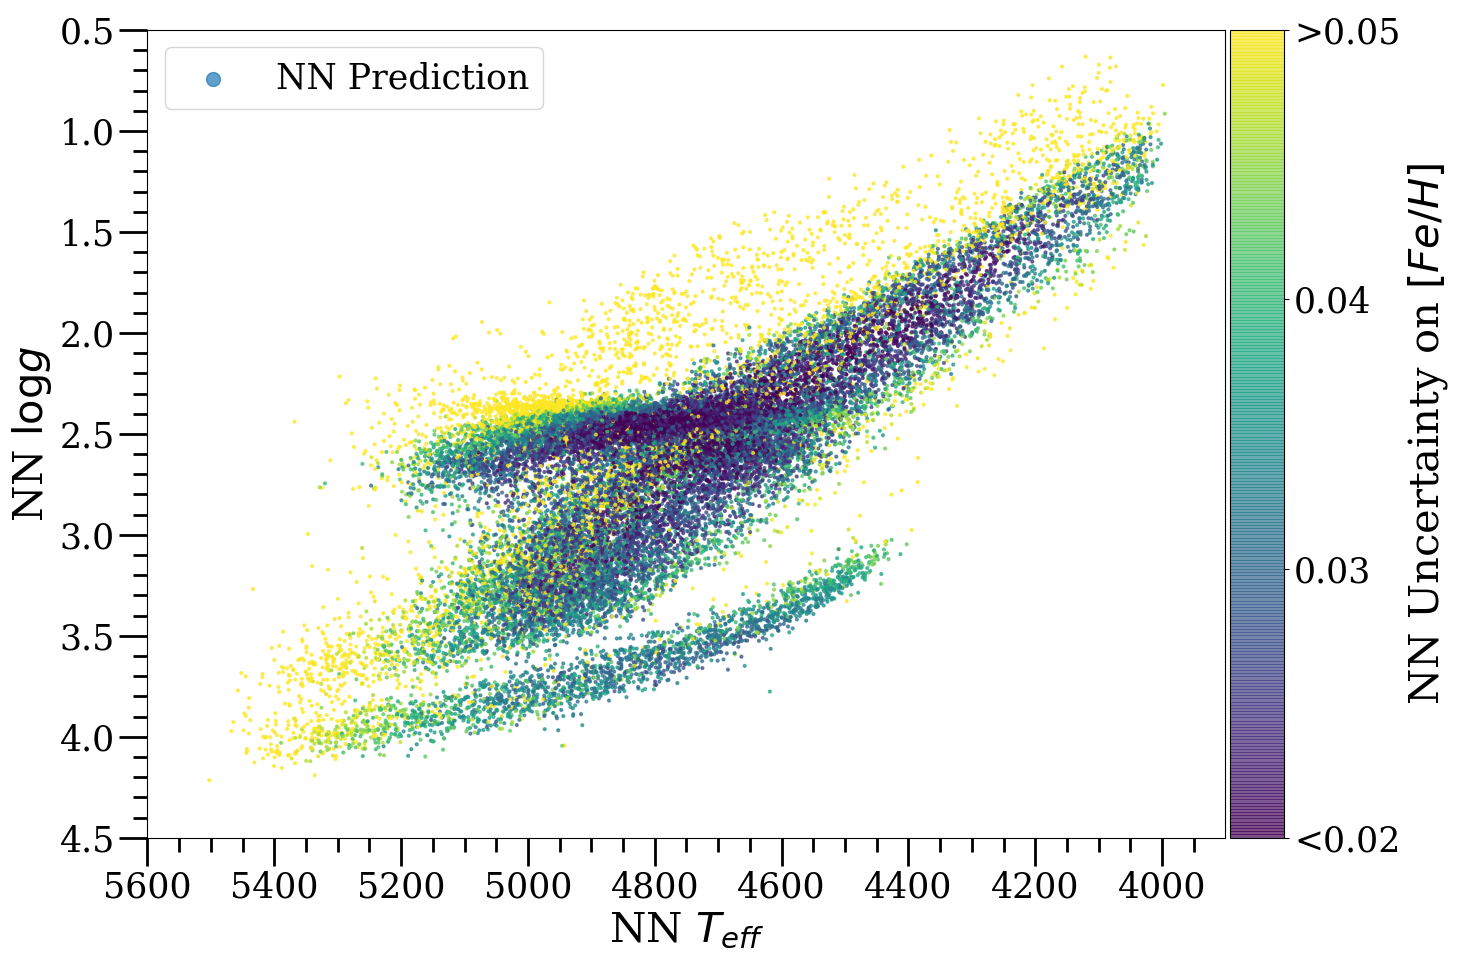

In [26]:
%matplotlib inline
import numpy as np
import pylab as plt
import astropy.io.ascii
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

fig = plt.figure(figsize=(15,10), dpi=100)
ax = plt.gca()
plt.scatter(pred[:,0], pred[:,1], s=4., c=np.clip(pred_err['total'][:,0], 25, 75), label=f'NN Prediction', alpha=0.7)
plt.xlabel('NN ' +"$T_{eff}$", fontsize=30)
plt.ylabel('NN '+'$\log{g}$', fontsize=30)
plt.xlim((3900., 5600))
plt.ylim((0.5, 4.5))
plt.legend(loc='best', fontsize=25, markerscale=5)
plt.minorticks_on()
plt.tick_params(labelsize=25, width=2, length=20, which='major')
plt.tick_params(width=2, length=10, which='minor')
ax.invert_xaxis()
ax.invert_yaxis()
#colorbar 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(cax=cax, ticks=[25, 35, 45, 55, 65, 75])
# cbar.set_clim(vmin=25, vmax=75)
cbar.ax.set_yticklabels(["<25", *[str(r) for r in [35, 45, 55, 65]], ">75"])       
cbar.ax.tick_params(labelsize=25)
cbar.set_label("NN Uncertainty on "+"$T_{eff}$", size=30)
plt.tight_layout()
plt.savefig('logg_teff_fe_tefferr.png')
plt.show()

fig = plt.figure(figsize=(15,10), dpi=100)
ax = plt.gca()
plt.scatter(pred[:,0], pred[:,1], s=4., c=np.clip(pred_err['total'][:,1], 0.02, 0.2), label=f'NN Prediction', alpha=0.7)
plt.xlabel('NN ' +"$T_{eff}$", fontsize=30)
plt.ylabel('NN '+'$\log{g}$', fontsize=30)
plt.xlim((3900., 5600))
plt.ylim((0.5, 4.5))
plt.legend(loc='best', fontsize=25, markerscale=5)
plt.minorticks_on()
plt.tick_params(labelsize=25, width=2, length=20, which='major')
plt.tick_params(width=2, length=10, which='minor')
ax.invert_xaxis()
ax.invert_yaxis()
#colorbar 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(cax=cax, ticks=[0.02, 0.06, 0.1, 0.14, 0.18, 0.2])
# cbar.set_clim(vmin=0.02, vmax=0.2)
cbar.ax.set_yticklabels(["<0.02", *[str(r) for r in [0.06, 0.1, 0.14, 0.18]], ">0.2"])       
cbar.ax.tick_params(labelsize=25)
cbar.set_label("NN Uncertainty on "+"$\log{g}$", size=30)     
plt.tight_layout()
plt.savefig('logg_teff_fe_loggerr.png')
plt.show()

fig = plt.figure(figsize=(15,10), dpi=100)
ax = plt.gca()
plt.scatter(pred[:,0], pred[:,1], s=4., c=np.clip(pred_err['total'][:, 19], 0.02, 0.05), label=f'NN Prediction', alpha=0.7)
plt.xlabel('NN ' +"$T_{eff}$", fontsize=30)
plt.ylabel('NN '+'$\log{g}$', fontsize=30)
plt.xlim((3900., 5600))
plt.ylim((0.5, 4.5))
plt.legend(loc='best', fontsize=25, markerscale=5)
plt.minorticks_on()
plt.tick_params(labelsize=25, width=2, length=20, which='major')
plt.tick_params(width=2, length=10, which='minor')
ax.invert_xaxis()
ax.invert_yaxis()
#colorbar 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(cax=cax, ticks=[0.02, 0.03, 0.04, 0.05])
# cbar.set_clim(vmin=0.02, vmax=0.055)
cbar.ax.set_yticklabels(["<0.02", *[str(r) for r in [0.03, 0.04]], ">0.05"])       
cbar.ax.tick_params(labelsize=25)
cbar.set_label("NN Uncertainty on "+"$[Fe/H]$", size=30)   
plt.tight_layout()
plt.savefig('logg_teff_fe_feherr.png')
plt.show()

In [2]:
from astropy.stats import mad_std as mad
import pandas as pd

residue = (pred - y)

bias = np.ma.median(np.ma.array(residue, mask=[y == -9999.]), axis=0)
scatter = mad(np.ma.array(residue, mask=[y == -9999.]), axis=0)

d = {'Name': bcnn.targetname, 'Bias': [f'{bias_single:.{3}f}' for bias_single in bias], 'Scatter': [f'{scatter_single:.{3}f}' for scatter_single in scatter]}
df = pd.DataFrame(data=d)
df

Name     Bias Scatter
0   teff  -20.210  30.423
1   logg    0.013   0.051
2      C   -0.003   0.040
3     C1    0.013   0.057
4      N   -0.004   0.041
5      O   -0.021   0.046
6     Na   -0.010   0.163
7     Mg   -0.000   0.027
8     Al   -0.038   0.071
9     Si    0.000   0.029
10     P   -0.027   0.104
11     S    0.006   0.051
12     K   -0.013   0.049
13    Ca   -0.015   0.033
14    Ti   -0.029   0.052
15   Ti2    0.065   0.172
16     V   -0.009   0.097
17    Cr   -0.002   0.048
18    Mn   -0.018   0.038
19    Fe   -0.004   0.020
20    Co   -0.019   0.144
21    Ni    0.003   0.029

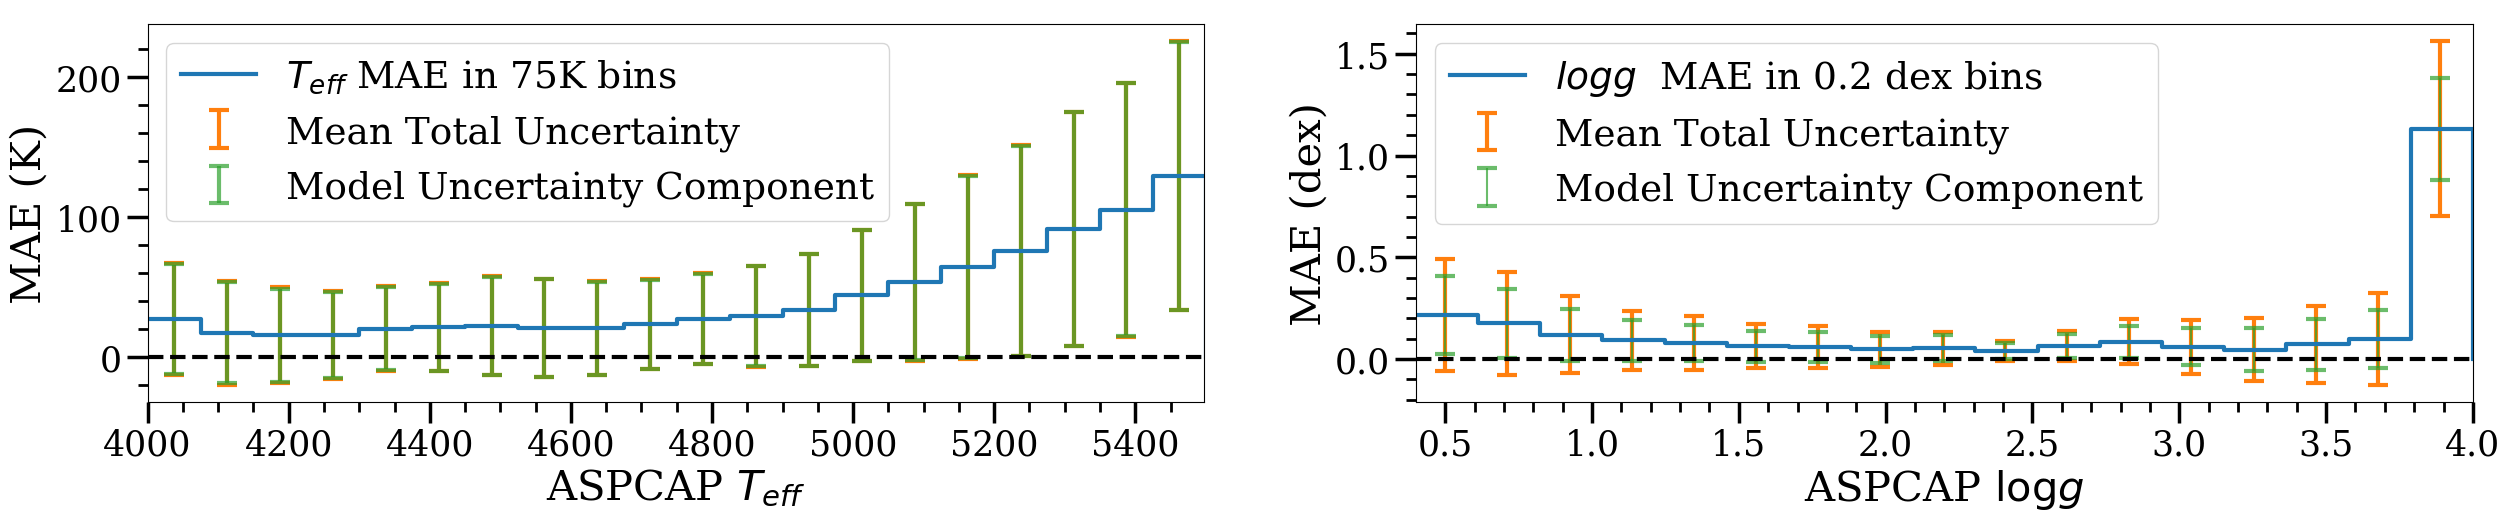

In [55]:
%matplotlib inline
import pylab as plt

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

# Teff
aspcap_idx = 0
number_bin = 20
low_teff = 4000.
high_teff = 5500.
mean_abs_diff_teff = []
mean_confidence_teff = []
mean_modelconfidence_teff = []
spaces_teff = np.linspace(low_teff, high_teff, number_bin+1)

# Binning

for i in range(number_bin):
    idx = [(y[:,aspcap_idx]<spaces_teff[i+1])&(y[:,aspcap_idx]>spaces_teff[i])]
    mean_abs_diff_teff.append(np.mean(np.abs(pred[:, aspcap_idx][idx] - y[:,aspcap_idx][idx])))
    mean_confidence_teff.append(np.mean(pred_err['total'][:, aspcap_idx][idx]))
    mean_modelconfidence_teff.append(np.mean(pred_err['model'][:, aspcap_idx][idx]))

mean_abs_diff_teff.append(0.)
mean_confidence_teff.append(0.)
mean_modelconfidence_teff.append(0.)

# Log(g)
aspcap_idx = 1
number_bin = 17
low_logg = 0.4  # because min(logg) in the dataset is 0.42667553
high_logg = 4.0
mean_abs_diff_logg = []
mean_confidence_logg = []
mean_modelconfidence_logg = []
spaces_logg = np.linspace(low_logg, high_logg, number_bin+1)

# Binning
for i in range(number_bin):
    idx = [(y[:,aspcap_idx]<spaces_logg[i+1])&(y[:,aspcap_idx]>spaces_logg[i])]
    mean_abs_diff_logg.append(np.mean(np.abs(pred[:, aspcap_idx][idx] - y[:,aspcap_idx][idx])))
    mean_confidence_logg.append(np.mean(pred_err['total'][:, aspcap_idx][idx]))
    mean_modelconfidence_logg.append(np.mean(pred_err['model'][:, aspcap_idx][idx]))

mean_abs_diff_logg.append(0.)
mean_confidence_logg.append(0.)
mean_modelconfidence_logg.append(0.)

# setup plots
f, ax = plt.subplots(1, 2, figsize=(30, 5), dpi=100)

ax[0].plot(spaces_teff, mean_abs_diff_teff, ls='steps-post', linewidth=3., label='$T_{eff}$' + ' MAE in 75K bins')
ax[0].errorbar(spaces_teff+37.5, mean_abs_diff_teff, yerr=mean_confidence_teff, linestyle='None', capsize=7, elinewidth=3., capthick=3., label='Mean Total Uncertainty')
ax[0].errorbar(spaces_teff+37.5, mean_abs_diff_teff, yerr=mean_modelconfidence_teff, linestyle='None', capsize=7, elinewidth=3., capthick=3., alpha=0.7, label='Model Uncertainty Component')
ax[0].set_xlabel('ASPCAP ' +"$T_{eff}$", fontsize=30)
ax[0].set_ylabel('MAE (K)', fontsize=30)
ax[0].set_xlim((low_teff, high_teff-2))
ax[0].axhline(0, ls='--', c='k', lw=3.)
ax[0].legend(loc='best', fontsize=27)
ax[0].minorticks_on()
ax[0].tick_params(labelsize=25, width=2.5, length=15, which='major')
ax[0].tick_params(width=2, length=7, which='minor')

ax[1].plot(spaces_logg, mean_abs_diff_logg, ls='steps-post', linewidth=3., label='$log{g}$' + '  MAE in 0.2 dex bins')
ax[1].errorbar(spaces_logg+0.1, mean_abs_diff_logg, yerr=mean_confidence_logg, linestyle='None', capsize=7, elinewidth=3., capthick=3., label='Mean Total Uncertainty')
ax[1].errorbar(spaces_logg+0.1, mean_abs_diff_logg, yerr=mean_modelconfidence_logg, linestyle='None', capsize=7, elinewidth=0., capthick=3., alpha=0.7, label='Model Uncertainty Component')
ax[1].set_xlabel('ASPCAP ' +"$\log{g}$", fontsize=30)
ax[1].set_ylabel('MAE (dex)', fontsize=30)
ax[1].set_xlim((low_logg, high_logg-0.001))
ax[1].axhline(0, ls='--', c='k', lw=3.)
ax[1].legend(loc='best', fontsize=27)
ax[1].minorticks_on()
ax[1].tick_params(labelsize=25, width=2.5, length=15, which='major')
ax[1].tick_params(width=2, length=7, which='minor')

# f.tight_layout()
f.savefig('delta_teff_logg_highSNR_2.png')

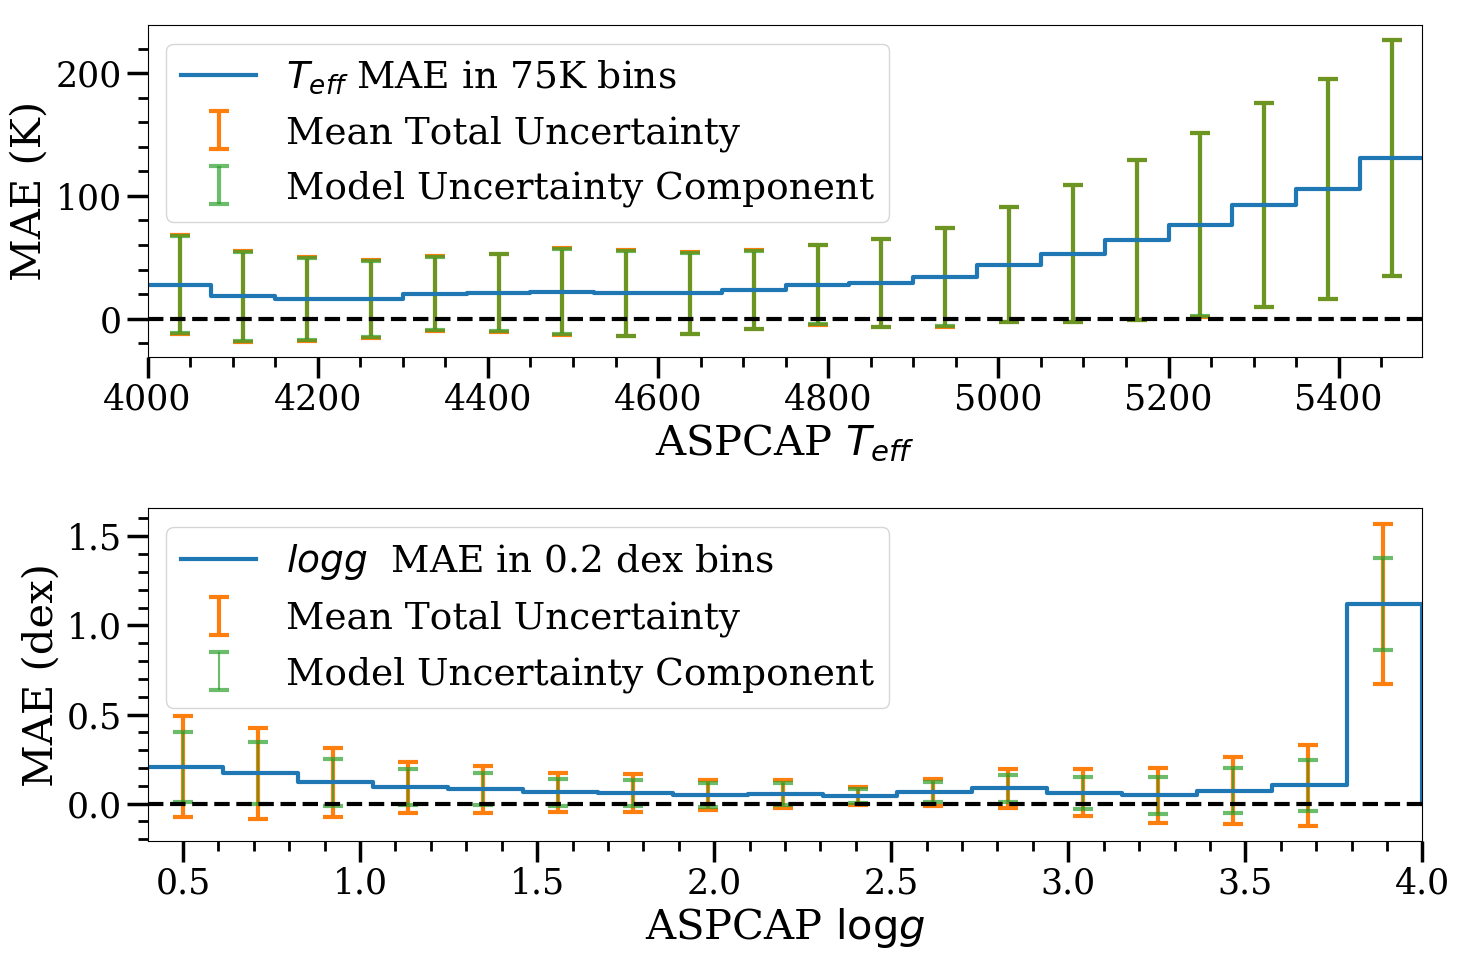

In [2]:
%matplotlib inline
import pylab as plt

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

# Teff
aspcap_idx = 0
number_bin = 20
low_teff = 4000.
high_teff = 5500.
mean_abs_diff_teff = []
mean_confidence_teff = []
mean_modelconfidence_teff = []
spaces_teff = np.linspace(low_teff, high_teff, number_bin+1)

# Binning

for i in range(number_bin):
    idx = [(y[:,aspcap_idx]<spaces_teff[i+1])&(y[:,aspcap_idx]>spaces_teff[i])]
    mean_abs_diff_teff.append(np.mean(np.abs(pred[:, aspcap_idx][idx] - y[:,aspcap_idx][idx])))
    mean_confidence_teff.append(np.mean(pred_err['total'][:, aspcap_idx][idx]))
    mean_modelconfidence_teff.append(np.mean(pred_err['model'][:, aspcap_idx][idx]))

mean_abs_diff_teff.append(0.)
mean_confidence_teff.append(0.)
mean_modelconfidence_teff.append(0.)

# Log(g)
aspcap_idx = 1
number_bin = 17
low_logg = 0.4  # because min(logg) in the dataset is 0.42667553
high_logg = 4.0
mean_abs_diff_logg = []
mean_confidence_logg = []
mean_modelconfidence_logg = []
spaces_logg = np.linspace(low_logg, high_logg, number_bin+1)

# Binning
for i in range(number_bin):
    idx = [(y[:,aspcap_idx]<spaces_logg[i+1])&(y[:,aspcap_idx]>spaces_logg[i])]
    mean_abs_diff_logg.append(np.mean(np.abs(pred[:, aspcap_idx][idx] - y[:,aspcap_idx][idx])))
    mean_confidence_logg.append(np.mean(pred_err['total'][:, aspcap_idx][idx]))
    mean_modelconfidence_logg.append(np.mean(pred_err['model'][:, aspcap_idx][idx]))

mean_abs_diff_logg.append(0.)
mean_confidence_logg.append(0.)
mean_modelconfidence_logg.append(0.)

# setup plots
f, ax = plt.subplots(2,figsize=(15,10), dpi=100)

ax[0].plot(spaces_teff, mean_abs_diff_teff, ls='steps-post', linewidth=3., label='$T_{eff}$' + ' MAE in 75K bins')
ax[0].errorbar(spaces_teff+37.5, mean_abs_diff_teff, yerr=mean_confidence_teff, linestyle='None', capsize=7, elinewidth=3., capthick=3., label='Mean Total Uncertainty')
ax[0].errorbar(spaces_teff+37.5, mean_abs_diff_teff, yerr=mean_modelconfidence_teff, linestyle='None', capsize=7, elinewidth=3., capthick=3., alpha=0.7, label='Model Uncertainty Component')
ax[0].set_xlabel('ASPCAP ' +"$T_{eff}$", fontsize=30)
ax[0].set_ylabel('MAE (K)', fontsize=30)
ax[0].set_xlim((low_teff, high_teff-2))
ax[0].axhline(0, ls='--', c='k', lw=3.)
ax[0].legend(loc='best', fontsize=27)
ax[0].minorticks_on()
ax[0].tick_params(labelsize=25, width=2.5, length=15, which='major')
ax[0].tick_params(width=2, length=7, which='minor')

ax[1].plot(spaces_logg, mean_abs_diff_logg, ls='steps-post', linewidth=3., label='$log{g}$' + '  MAE in 0.2 dex bins')
ax[1].errorbar(spaces_logg+0.1, mean_abs_diff_logg, yerr=mean_confidence_logg, linestyle='None', capsize=7, elinewidth=3., capthick=3., label='Mean Total Uncertainty')
ax[1].errorbar(spaces_logg+0.1, mean_abs_diff_logg, yerr=mean_modelconfidence_logg, linestyle='None', capsize=7, elinewidth=0., capthick=3., alpha=0.7, label='Model Uncertainty Component')
ax[1].set_xlabel('ASPCAP ' +"$\log{g}$", fontsize=30)
ax[1].set_ylabel('MAE (dex)', fontsize=30)
ax[1].set_xlim((low_logg, high_logg-0.001))
ax[1].axhline(0, ls='--', c='k', lw=3.)
ax[1].legend(loc='best', fontsize=27)
ax[1].minorticks_on()
ax[1].tick_params(labelsize=25, width=2.5, length=15, which='major')
ax[1].tick_params(width=2, length=7, which='minor')

f.tight_layout()
f.savefig('delta_teff_logg_highSNR.png')

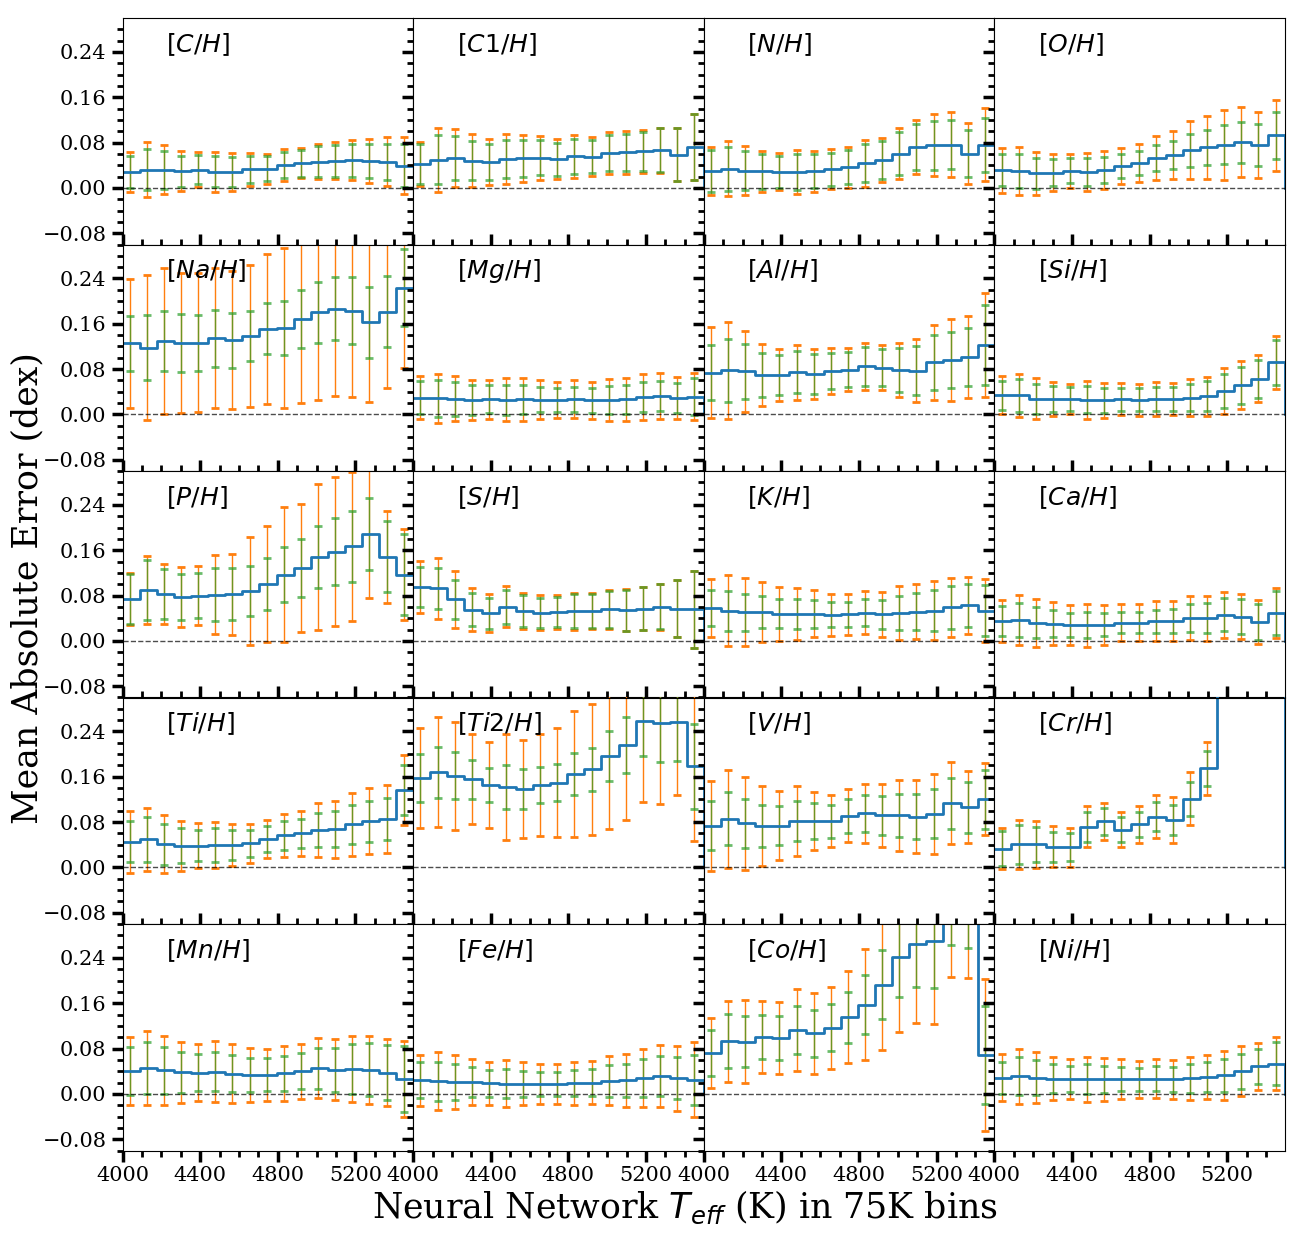

In [3]:
%matplotlib inline
import pylab as plt
from matplotlib.ticker import NullFormatter,MultipleLocator, FormatStrFormatter
from astroNN.nn.numpy import mean_absolute_error
plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

# basic parameters
aspcap_idx = 2
number_bin = 17
low_x = -2.6
high_x = 0.8
mean_abs_diff_x = []
mean_confidence_x = []
spaces_teff_x = np.linspace(low_teff, high_teff, number_bin+1)

# setup plots
f, ax = plt.subplots(5,4,figsize=(15,15), dpi=100, sharex=True, sharey=False)

xmajorLocator = MultipleLocator(400)
ymajorLocator = MultipleLocator(0.08)

aspcap_idx = 2

for i in range(5):
    for j in range(4):
        mean_abs_diff_x = []
        mean_confidence_x = []
        mean_modelconfidence_x = []
        if aspcap_idx > 22:
            aspcap_idx = 22
        
        for ii in range(number_bin):
            idx = [(pred[:,0]<spaces_teff_x[ii+1])&(pred[:,0]>spaces_teff_x[ii])]
            mean_abs_diff_x.append(mean_absolute_error(pred[:, aspcap_idx][idx], y[:,aspcap_idx][idx]))
            mean_confidence_x.append(np.mean(pred_err['total'][:, aspcap_idx][idx]))
            mean_modelconfidence_x.append(np.mean(pred_err['model'][:, aspcap_idx][idx]))

        mean_abs_diff_x.append(0.)
        mean_confidence_x.append(0.)
        mean_modelconfidence_x.append(0.)
        
        ax[i,j].plot(spaces_teff_x, mean_abs_diff_x, ls='steps-post', linewidth=2., label='$T_{eff}$')
        ax[i,j].errorbar(spaces_teff_x+37.5, mean_abs_diff_x, yerr=mean_confidence_x, linestyle='None', capsize=3, elinewidth=1., capthick=2.)
        ax[i,j].errorbar(spaces_teff_x+37.5, mean_abs_diff_x, yerr=mean_modelconfidence_x, linestyle='None', capsize=3, elinewidth=1., capthick=2., alpha=0.7)
        ax[i,j].set_xlim((low_teff, high_teff-2))
        ax[i,j].set_ylim((-0.1, 0.3))
        ax[i,j].axhline(0, ls='--', c='k', lw=1., alpha=0.7)
        ax[i,j].annotate(f"$[{bcnn.targetname[aspcap_idx]}/H]$", xy=(0.15,0.85),xycoords='axes fraction', fontsize=18)
        if j == 0:
            ax[i,j].yaxis.set_major_locator(ymajorLocator)
        else:
            ax[i,j].yaxis.set_major_formatter(NullFormatter())
            ax[i,j].yaxis.set_major_locator(ymajorLocator)
        if i == 4:
            ax[i,j].xaxis.set_major_locator(xmajorLocator)
        else:
            ax[i,j].xaxis.set_tick_params(direction='in', which='both')
        ax[i,j].minorticks_on()
        ax[i,j].tick_params(labelsize=15, width=2.5, length=8, which='major')
        ax[i,j].tick_params(width=2, length=4, which='minor')
        aspcap_idx += 1
f.text(0.5,0.08,'Neural Network ' + "$T_{eff}$" + " " + "(K) in 75K bins", fontdict={'fontsize':25}, ha='center')
f.text(0.05,0.5,"Mean Absolute Error (dex)",fontdict={'fontsize':25},rotation=90, va='center')
f.subplots_adjust(wspace=0,hspace=0)
f.savefig('delta_xh_teff_highSNR.png')

C:\Users\Henry\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Henry\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Henry\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


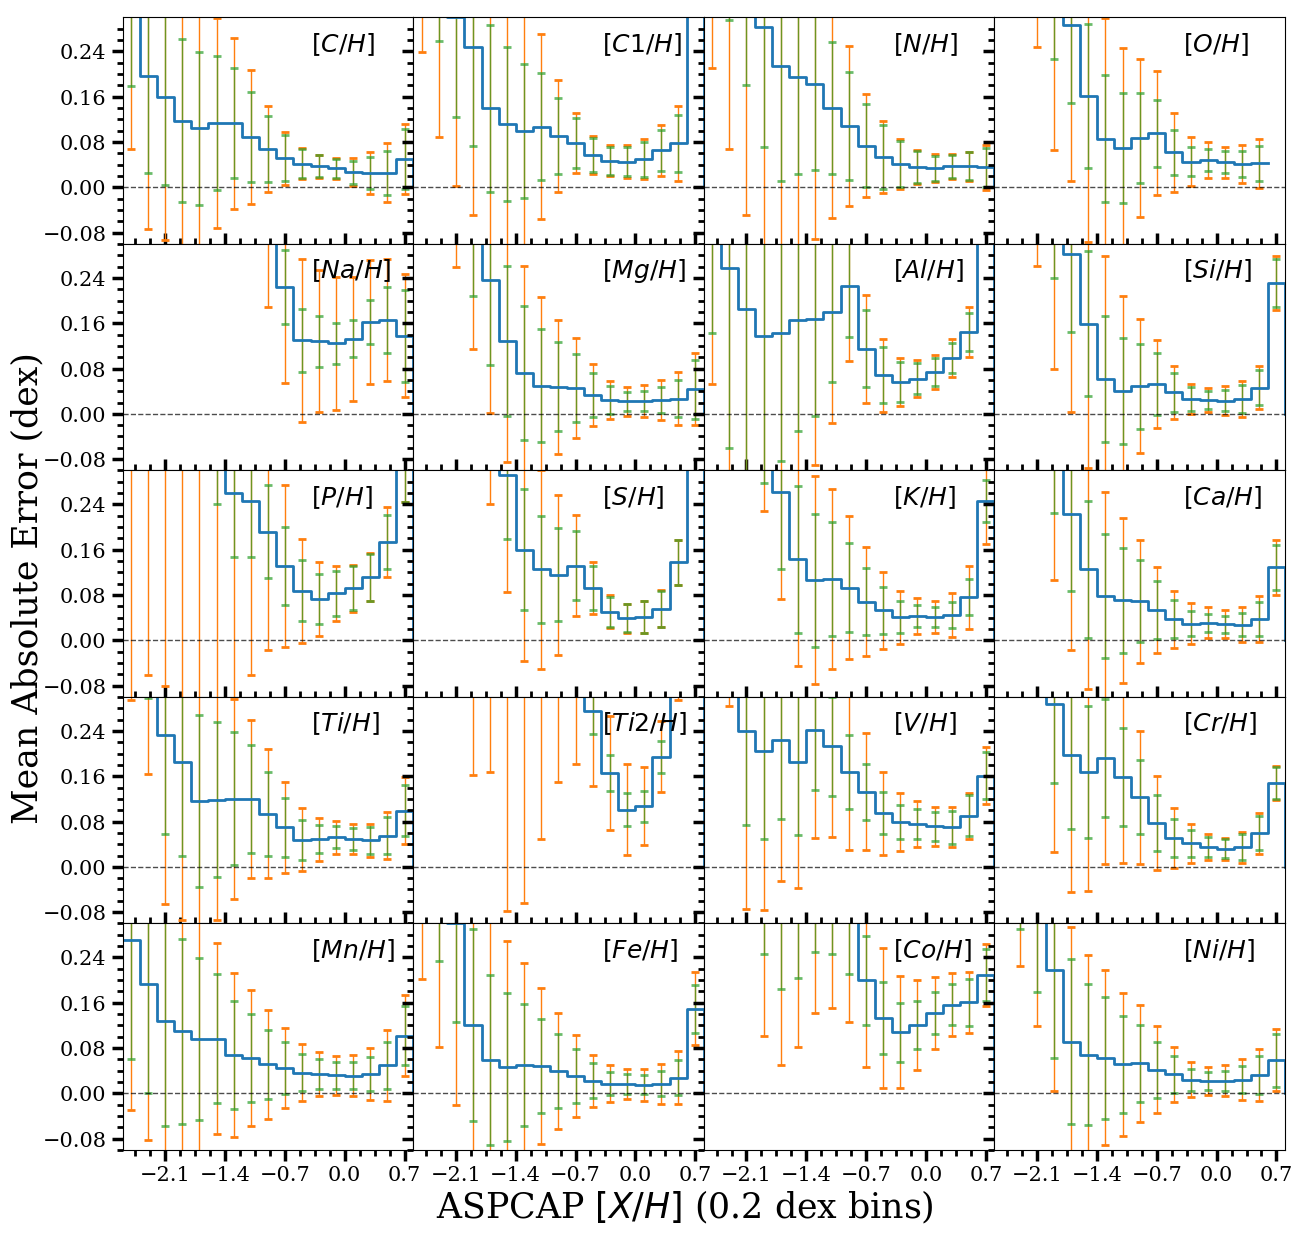

In [4]:
%matplotlib inline
import pylab as plt
from matplotlib.ticker import NullFormatter,MultipleLocator, FormatStrFormatter

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

# basic parameters
number_bin = 17
low_x = -2.6
high_x = 0.8
mean_abs_diff_x = []
mean_confidence_x = []
spaces_x = np.linspace(low_x, high_x, number_bin+1)

# setup plots
f, ax = plt.subplots(5,4,figsize=(15,15), dpi=100, sharex=True, sharey=False)

xmajorLocator = MultipleLocator(0.7)
ymajorLocator = MultipleLocator(0.08)

aspcap_idx = 2

for i in range(5):
    for j in range(4):
        mean_abs_diff_x = []
        mean_confidence_x = []
        mean_modelconfidence_x = []
        if aspcap_idx > 22:
            aspcap_idx = 22
        
        for ii in range(number_bin):
            idx = [(y[:,aspcap_idx]<spaces_x[ii+1])&(y[:,aspcap_idx]>spaces_x[ii])]
            mean_abs_diff_x.append(np.mean(np.abs(pred[:, aspcap_idx][idx] - y[:,aspcap_idx][idx])))
            mean_confidence_x.append(np.mean(pred_err['total'][:, aspcap_idx][idx]))
            mean_modelconfidence_x.append(np.mean(pred_err['model'][:, aspcap_idx][idx]))

        mean_abs_diff_x.append(0.)
        mean_confidence_x.append(0.)
        mean_modelconfidence_x.append(0.)
        
        ax[i,j].plot(spaces_x, mean_abs_diff_x, ls='steps-post', linewidth=2., label='$T_{eff}$')
        ax[i,j].errorbar(spaces_x+0.1, mean_abs_diff_x, yerr=mean_confidence_x, linestyle='None', capsize=3, elinewidth=1., capthick=2.)
        ax[i,j].errorbar(spaces_x+0.1, mean_abs_diff_x, yerr=mean_modelconfidence_x, linestyle='None', capsize=3, elinewidth=1., capthick=2., alpha=0.7)
        ax[i,j].set_xlim((low_x, high_x))
        ax[i,j].set_ylim((-0.1, 0.3))
        ax[i,j].axhline(0, ls='--', c='k', lw=1., alpha=0.7)
        ax[i,j].annotate(f"$[{bcnn.targetname[aspcap_idx]}/H]$", xy=(0.65,0.85),xycoords='axes fraction', fontsize=18)
        if j == 0:
            ax[i,j].yaxis.set_major_locator(ymajorLocator)
        else:
            ax[i,j].yaxis.set_major_formatter(NullFormatter())
            ax[i,j].yaxis.set_major_locator(ymajorLocator)
        if i == 4:
            ax[i,j].xaxis.set_major_locator(xmajorLocator)
        else:
            ax[i,j].xaxis.set_tick_params(direction='in', which='both')
        ax[i,j].minorticks_on()
        ax[i,j].tick_params(labelsize=15, width=2.5, length=8, which='major')
        ax[i,j].tick_params(width=2, length=4, which='minor')
        aspcap_idx += 1
        
f.text(0.5,0.08,"ASPCAP "+"$[X/H]$" + " (0.2 dex bins)",fontdict={'fontsize':25}, ha='center')
f.text(0.05,0.5,"Mean Absolute Error (dex)",fontdict={'fontsize':25},rotation=90, va='center')
f.subplots_adjust(wspace=0,hspace=0)
f.savefig('delta_xh_highSNR.png')

## Jacobian

In [11]:
metal_poor_jac = bcnn.jacobian(x[pred[:, 19] < -1.5], mean_output=True, denormalize=True)
metal_rich_jac = bcnn.jacobian(x[pred[:, 19] > 0.4], mean_output=True, denormalize=True)

Finished all gradient calculation, 30.09 seconds elapsed
Finished all gradient calculation, 26.19 seconds elapsed


In [3]:
# define HBR lines for plotting
HBR_blue_lines = np.array([15264.717, 15345.992, 15443.148, 15560.708]) - 15000.
HBR_green_lines = np.array([15884.888, 16113.721, 16411.681]) - 15000.
HBR_red_lines = np.array([16811.117]) - 15000.

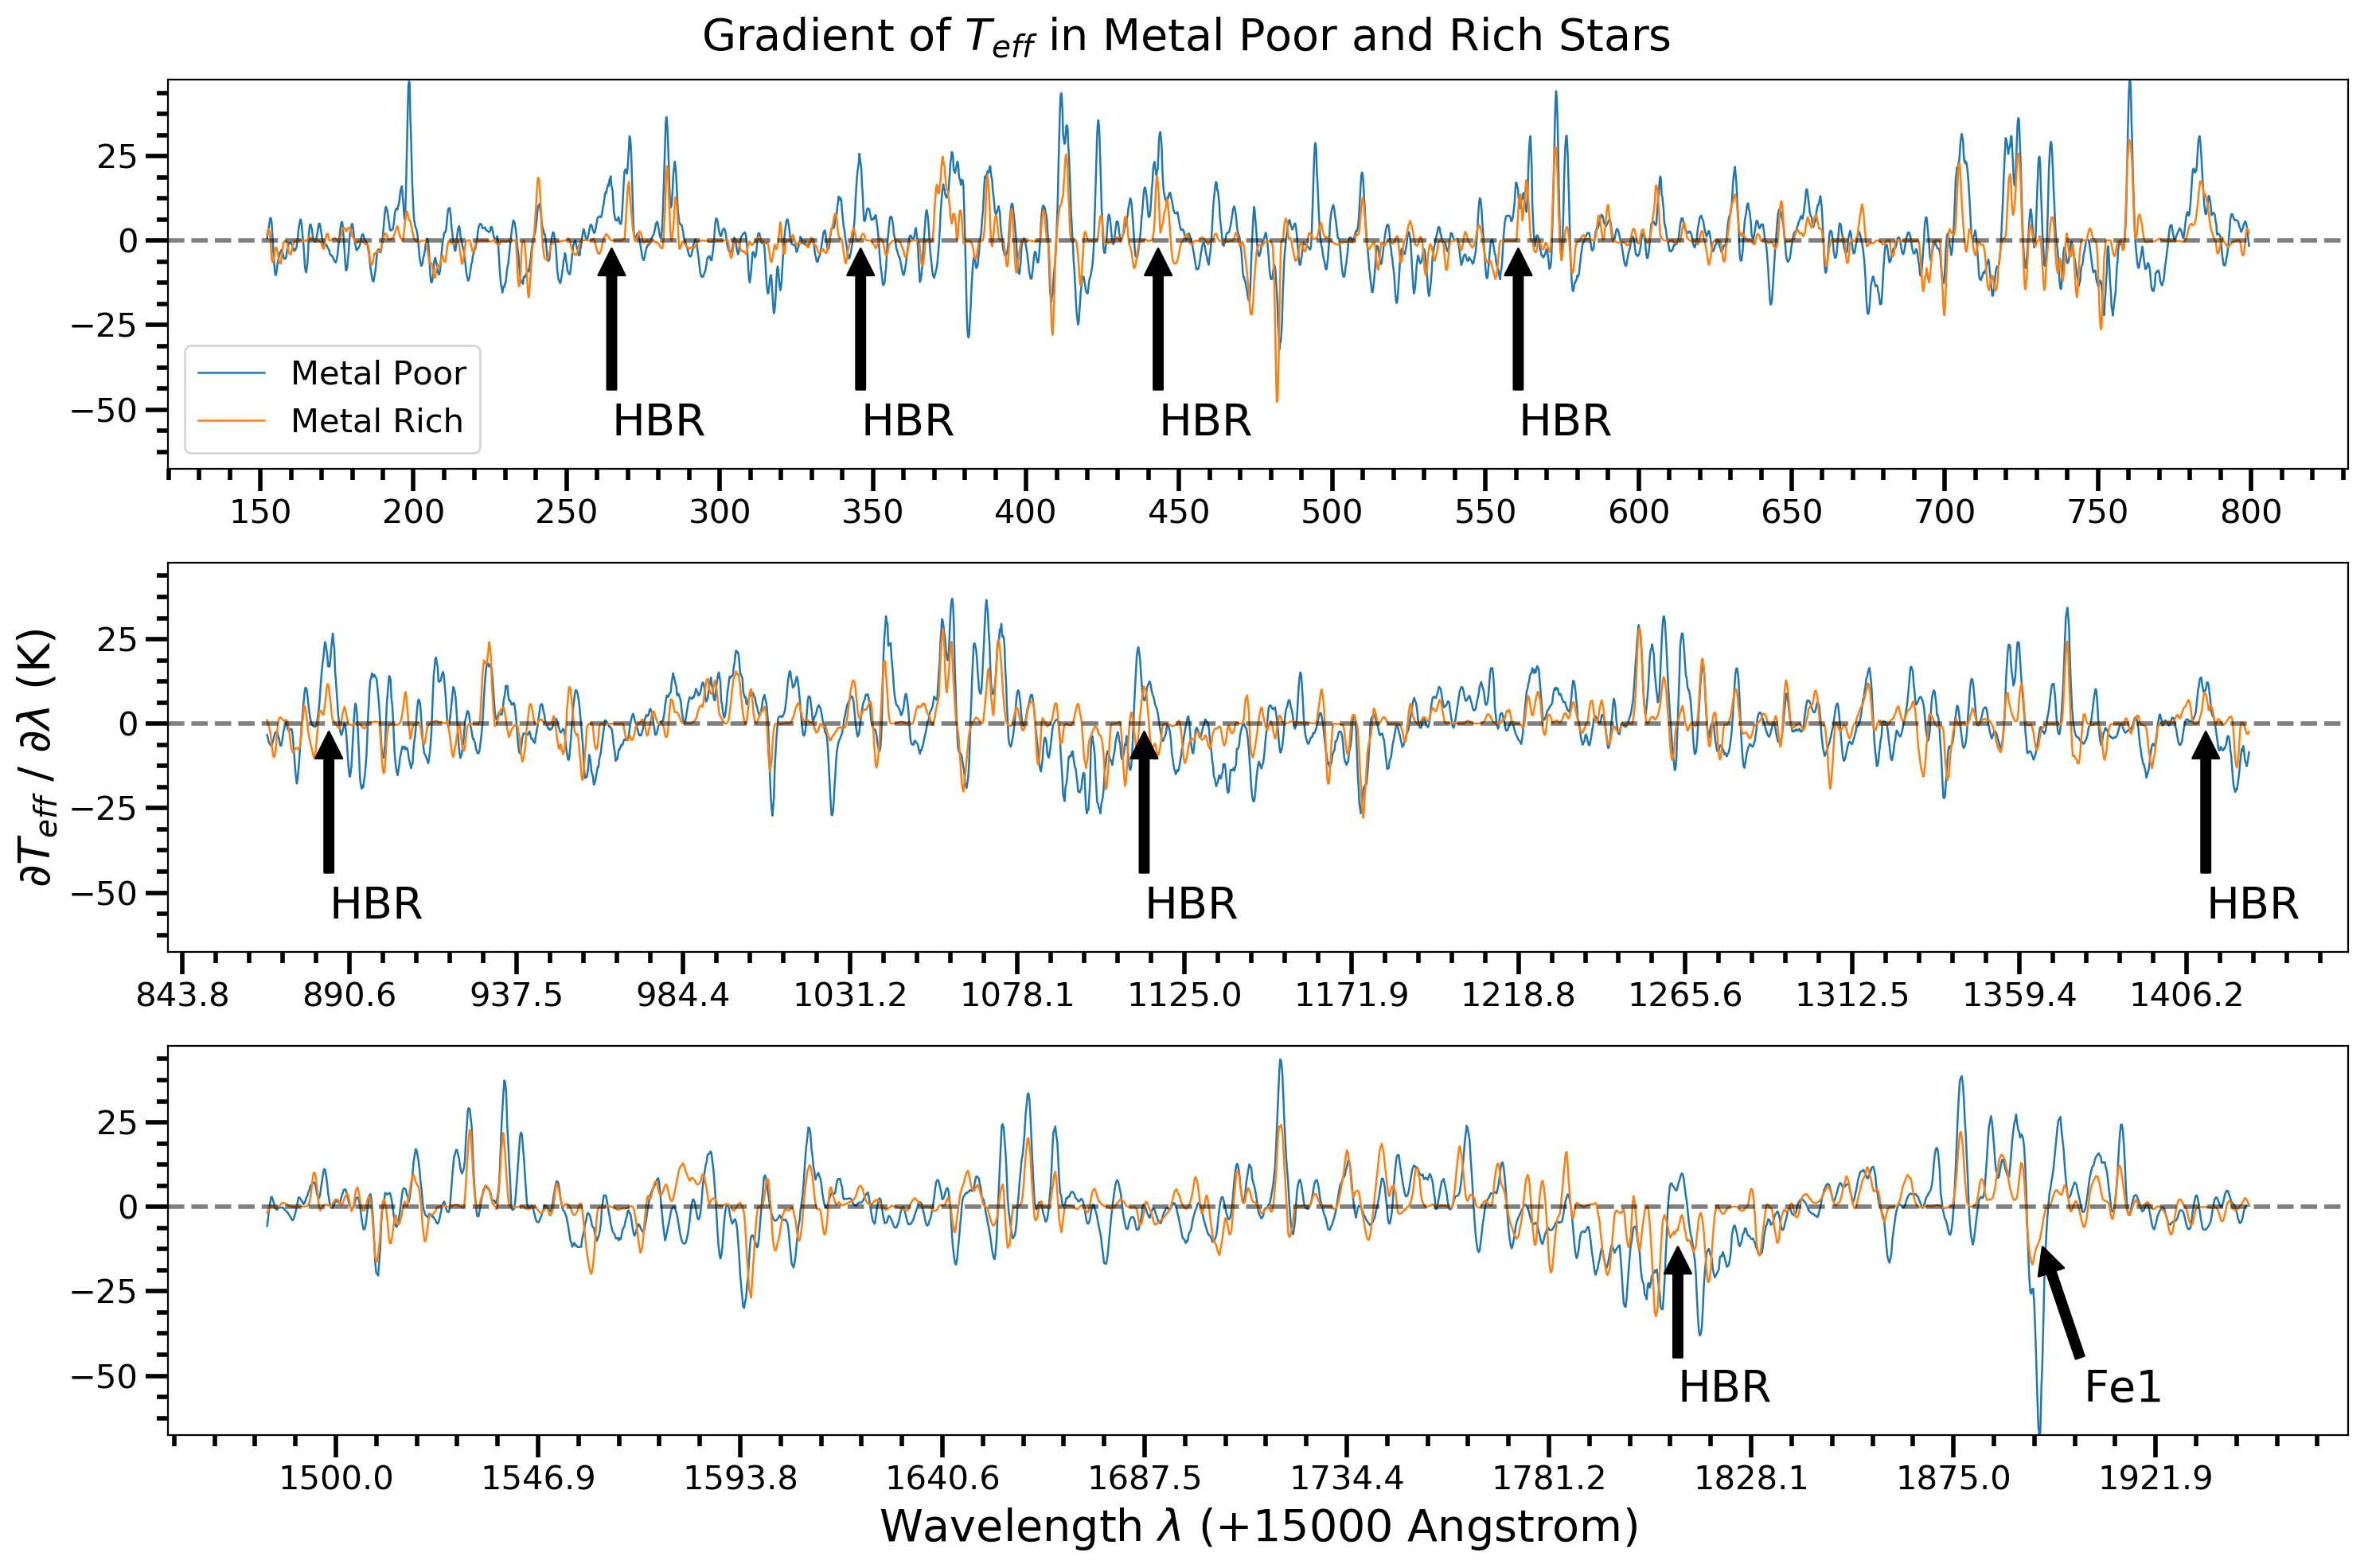

In [42]:
%matplotlib inline
import pylab as plt
import matplotlib.ticker as ticker
from astroNN.apogee.chips import wavelength_solution, chips_split

lambda_blue, lambda_green, lambda_red = wavelength_solution(dr=14)

lambda_blue -= 15000
lambda_green -= 15000
lambda_red -= 15000

nn_neuron = 0
target_name = 'T_{eff}'

fig = plt.figure(figsize=(15, 10), dpi=200)
metal_poor_jac_b, metal_poor_jac_g, metal_poor_jac_r = chips_split(metal_poor_jac, dr=14)
metal_rich_jac_b, metal_rich_jac_g, metal_rich_jac_r = chips_split(metal_rich_jac, dr=14)

min_jacpoint = np.min([np.min(metal_poor_jac[nn_neuron]), np.min(metal_rich_jac[nn_neuron])])
max_jacpoint = np.max([np.max(metal_poor_jac[nn_neuron]), np.max(metal_rich_jac[nn_neuron])])

fig.suptitle(f'Gradient of ${target_name}$ in Metal Poor and Rich Stars', fontsize=20)
ax1 = fig.add_subplot(311)
ax1.plot(lambda_blue, metal_poor_jac_b[nn_neuron], linewidth=0.9, label='Metal Poor')
ax1.plot(lambda_blue, metal_rich_jac_b[nn_neuron], linewidth=0.9, label='Metal Rich')
ax1.set_ylim((min_jacpoint, max_jacpoint))
ax2 = fig.add_subplot(312)
ax2.set_ylabel(r'$\partial$' + f'${target_name}$' + ' / ' + r'$\partial\lambda$ (K)', fontsize=20)
ax2.plot(lambda_green, metal_poor_jac_g[nn_neuron], linewidth=0.9, label='Metal Poor')
ax2.plot(lambda_green, metal_rich_jac_g[nn_neuron], linewidth=0.9, label='Metal Rich')
ax2.set_ylim((min_jacpoint, max_jacpoint))
ax3 = fig.add_subplot(313)
ax3.plot(lambda_red, metal_poor_jac_r[nn_neuron], linewidth=0.9, label='Metal Poor')
ax3.plot(lambda_red, metal_rich_jac_r[nn_neuron], linewidth=0.9, label='Metal Rich')
ax3.set_ylim((min_jacpoint, max_jacpoint))

ax1.tick_params(labelsize=15, width=2, length=10, which='major')
ax1.tick_params(width=2, length=5, which='minor')
ax2.tick_params(labelsize=15, width=2, length=10, which='major')
ax2.tick_params(width=2, length=5, which='minor')
ax3.tick_params(labelsize=15, width=2, length=10, which='major')
ax3.tick_params(width=2, length=5, which='minor')
ax1.legend(loc='best', fontsize=15)
ax3.set_xlabel(r'Wavelength $\lambda$ (+15000 Angstrom)', fontsize=20)

ax1.axhline(0, ls='--', c='k', lw=2, alpha=0.5)
ax2.axhline(0, ls='--', c='k', lw=2, alpha=0.5)
ax3.axhline(0, ls='--', c='k', lw=2, alpha=0.5)

for HBR_blue_line in HBR_blue_lines:
    ax1.annotate('HBR', xy=(HBR_blue_line, -0.01), xytext=(HBR_blue_line, min_jacpoint + 10.), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

for HBR_green_line in HBR_green_lines:
    ax2.annotate('HBR', xy=(HBR_green_line, -0.01), xytext=(HBR_green_line, min_jacpoint + 10.), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

for HBR_red_line in HBR_red_lines:
    ax3.annotate('HBR', xy=(HBR_red_line, -10), xytext=(HBR_red_line, min_jacpoint + 10.), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

ax3.annotate('Fe1', xy=(1895.183, -10), xytext=(1895.183 + 10., min_jacpoint + 10.), 
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)
    
tick_spacing = 75
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing / 1.5))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing / 1.6))
ax3.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing / 1.6))
ax1.minorticks_on()
ax2.minorticks_on()
ax3.minorticks_on()
plt.tight_layout(rect=[0, 0.00, 1, 0.96])
plt.savefig("jac_teff_fe.png")

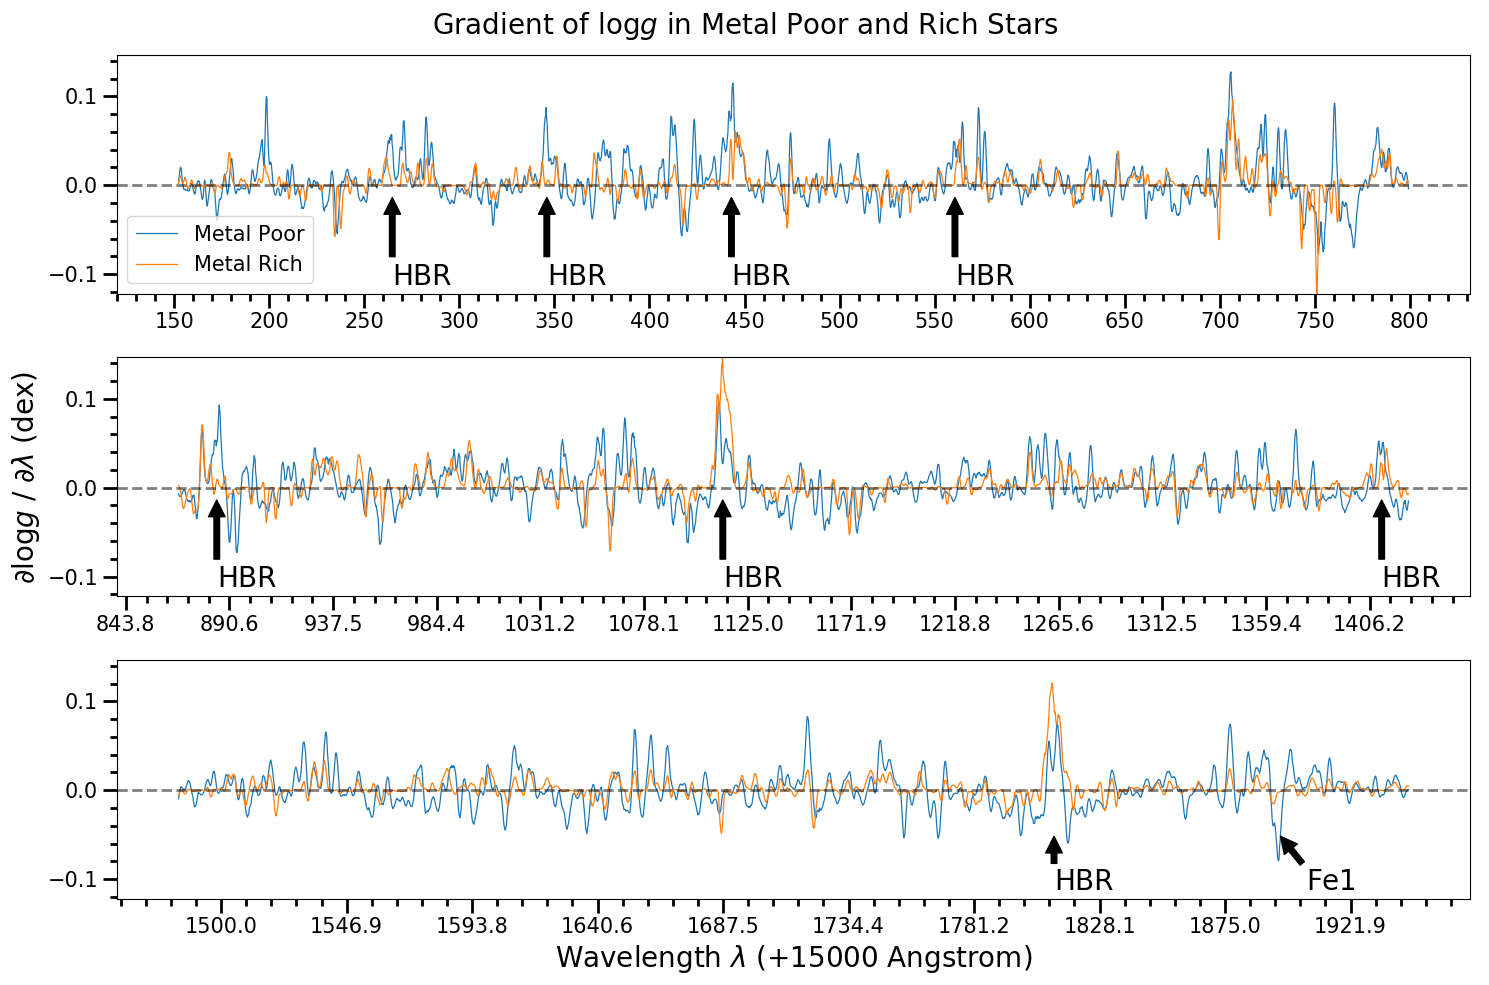

In [43]:
%matplotlib inline
import pylab as plt
import matplotlib.ticker as ticker
from astroNN.apogee.chips import wavelength_solution, chips_split

lambda_blue, lambda_green, lambda_red = wavelength_solution(dr=14)

lambda_blue -= 15000
lambda_green -= 15000
lambda_red -= 15000

nn_neuron = 1
target_name = '\log{g}'

fig = plt.figure(figsize=(15, 10), dpi=100)
metal_poor_jac_b, metal_poor_jac_g, metal_poor_jac_r = chips_split(metal_poor_jac, dr=14)
metal_rich_jac_b, metal_rich_jac_g, metal_rich_jac_r = chips_split(metal_rich_jac, dr=14)

min_jacpoint = np.min([np.min(metal_poor_jac[nn_neuron]), np.min(metal_rich_jac[nn_neuron])])
max_jacpoint = np.max([np.max(metal_poor_jac[nn_neuron]), np.max(metal_rich_jac[nn_neuron])])

fig.suptitle(f'Gradient of ${target_name}$ in Metal Poor and Rich Stars', fontsize=20)
ax1 = fig.add_subplot(311)
ax1.plot(lambda_blue, metal_poor_jac_b[nn_neuron], linewidth=0.9, label='Metal Poor')
ax1.plot(lambda_blue, metal_rich_jac_b[nn_neuron], linewidth=0.9, label='Metal Rich')
ax1.set_ylim((min_jacpoint, max_jacpoint))

ax2 = fig.add_subplot(312)
ax2.set_ylabel(r'$\partial$' + f'${target_name}$' + ' / ' + r'$\partial\lambda$ (dex)', fontsize=20)
ax2.plot(lambda_green, metal_poor_jac_g[nn_neuron], linewidth=0.9, label='Metal Poor')
ax2.plot(lambda_green, metal_rich_jac_g[nn_neuron], linewidth=0.9, label='Metal Rich')
ax2.set_ylim((min_jacpoint, max_jacpoint))

ax3 = fig.add_subplot(313)
ax3.plot(lambda_red, metal_poor_jac_r[nn_neuron], linewidth=0.9, label='Metal Poor')
ax3.plot(lambda_red, metal_rich_jac_r[nn_neuron], linewidth=0.9, label='Metal Rich')
ax3.set_ylim((min_jacpoint, max_jacpoint))

ax1.tick_params(labelsize=15, width=2, length=10, which='major')
ax1.tick_params(width=2, length=5, which='minor')
ax2.tick_params(labelsize=15, width=2, length=10, which='major')
ax2.tick_params(width=2, length=5, which='minor')
ax3.tick_params(labelsize=15, width=2, length=10, which='major')
ax3.tick_params(width=2, length=5, which='minor')
ax1.legend(loc='best', fontsize=15)
ax3.set_xlabel(r'Wavelength $\lambda$ (+15000 Angstrom)', fontsize=20)

ax1.axhline(0, ls='--', c='k', lw=2, alpha=0.5)
ax2.axhline(0, ls='--', c='k', lw=2, alpha=0.5)
ax3.axhline(0, ls='--', c='k', lw=2, alpha=0.5)

for HBR_blue_line in HBR_blue_lines:
    ax1.annotate('HBR', xy=(HBR_blue_line, -0.01), xytext=(HBR_blue_line, min_jacpoint + 0.01), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

for HBR_green_line in HBR_green_lines:
    ax2.annotate('HBR', xy=(HBR_green_line, -0.01), xytext=(HBR_green_line, min_jacpoint + 0.01), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

for HBR_red_line in HBR_red_lines:
    ax3.annotate('HBR', xy=(HBR_red_line, -0.05), xytext=(HBR_red_line, min_jacpoint + 0.01), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

ax3.annotate('Fe1', xy=(1895.183, -0.05), xytext=(1895.183 + 10., min_jacpoint + 0.01), 
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)
    
tick_spacing = 75
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing / 1.5))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing / 1.6))
ax3.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing / 1.6))
ax1.minorticks_on()
ax2.minorticks_on()
ax3.minorticks_on()
plt.tight_layout(rect=[0, 0.00, 1, 0.96])
plt.savefig("jac_logg_fe.png")

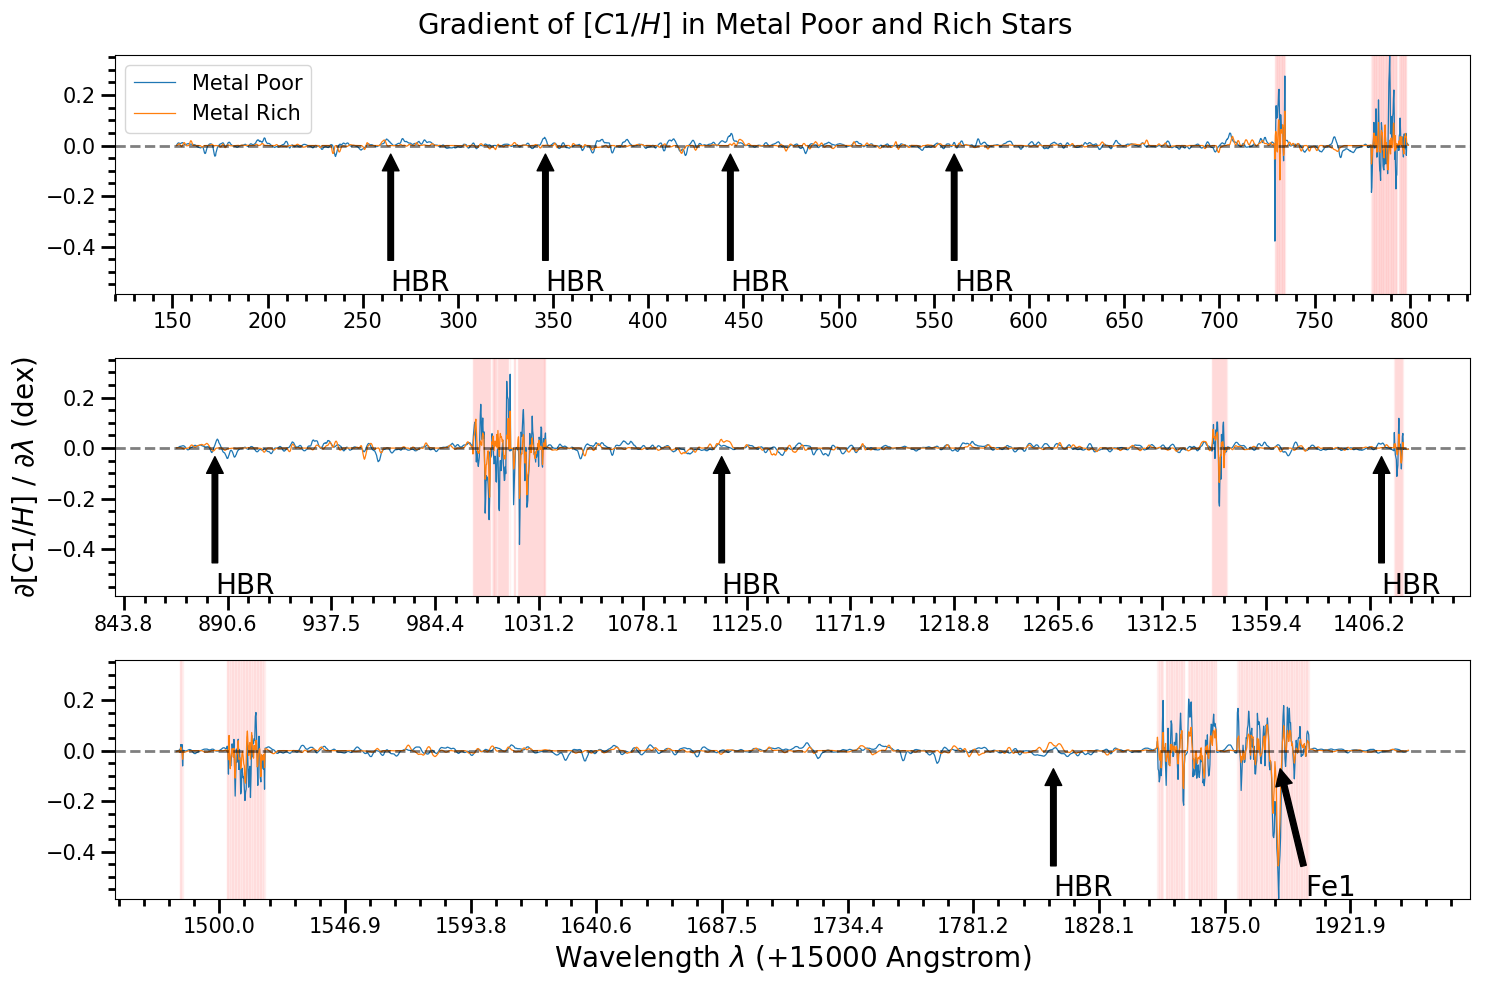

In [44]:
%matplotlib inline
import pylab as plt
import matplotlib.ticker as ticker
from astroNN.apogee.chips import wavelength_solution, chips_split
from astroNN.apogee import aspcap_mask

lambda_blue, lambda_green, lambda_red = wavelength_solution(dr=14)

lambda_blue -= 15000
lambda_green -= 15000
lambda_red -= 15000

nn_neuron = 3
target_name = '[C1/H]'

fig = plt.figure(figsize=(15, 10), dpi=100)
metal_poor_jac_b, metal_poor_jac_g, metal_poor_jac_r = chips_split(metal_poor_jac, dr=14)
metal_rich_jac_b, metal_rich_jac_g, metal_rich_jac_r = chips_split(metal_rich_jac, dr=14)
c1_mask_b, c1_mask_g, c1_mask_r = chips_split(aspcap_mask('c1', dr=14), dr=14)

min_jacpoint = np.min([np.min(metal_poor_jac[nn_neuron]), np.min(metal_rich_jac[nn_neuron])])
max_jacpoint = np.max([np.max(metal_poor_jac[nn_neuron]), np.max(metal_rich_jac[nn_neuron])])

fig.suptitle(f'Gradient of ${target_name}$ in Metal Poor and Rich Stars', fontsize=20)
ax1 = fig.add_subplot(311)
for ll in lambda_blue[c1_mask_b[0]]:
    ax1.axvline(ll, c='r', alpha=0.05, lw=1.)
ax1.plot(lambda_blue, metal_poor_jac_b[nn_neuron], linewidth=0.9, label='Metal Poor')
ax1.plot(lambda_blue, metal_rich_jac_b[nn_neuron], linewidth=0.9, label='Metal Rich')
ax1.set_ylim((min_jacpoint, max_jacpoint))

ax2 = fig.add_subplot(312)
for ll in lambda_green[c1_mask_g[0]]:
    ax2.axvline(ll, c='r', alpha=0.05, lw=1.)
ax2.set_ylabel(r'$\partial$' + f'${target_name}$' + ' / ' + r'$\partial\lambda$ (dex)', fontsize=20)
ax2.plot(lambda_green, metal_poor_jac_g[nn_neuron], linewidth=0.9, label='Metal Poor')
ax2.plot(lambda_green, metal_rich_jac_g[nn_neuron], linewidth=0.9, label='Metal Rich')
ax2.set_ylim((min_jacpoint, max_jacpoint))

ax3 = fig.add_subplot(313)
for ll in lambda_red[c1_mask_r[0]]:
    ax3.axvline(ll, c='r', alpha=0.05, lw=1.)
ax3.plot(lambda_red, metal_poor_jac_r[nn_neuron], linewidth=0.9, label='Metal Poor')
ax3.plot(lambda_red, metal_rich_jac_r[nn_neuron], linewidth=0.9, label='Metal Rich')
ax3.set_ylim((min_jacpoint, max_jacpoint))

ax1.tick_params(labelsize=15, width=2, length=10, which='major')
ax1.tick_params(width=2, length=5, which='minor')
ax2.tick_params(labelsize=15, width=2, length=10, which='major')
ax2.tick_params(width=2, length=5, which='minor')
ax3.tick_params(labelsize=15, width=2, length=10, which='major')
ax3.tick_params(width=2, length=5, which='minor')
ax1.legend(loc='best', fontsize=15)
ax3.set_xlabel(r'Wavelength $\lambda$ (+15000 Angstrom)', fontsize=20)

ax1.axhline(0, ls='--', c='k', lw=2, alpha=0.5)
ax2.axhline(0, ls='--', c='k', lw=2, alpha=0.5)
ax3.axhline(0, ls='--', c='k', lw=2, alpha=0.5)

for HBR_blue_line in HBR_blue_lines:
    ax1.annotate('HBR', xy=(HBR_blue_line, -0.01), xytext=(HBR_blue_line, min_jacpoint + 0.01), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

for HBR_green_line in HBR_green_lines:
    ax2.annotate('HBR', xy=(HBR_green_line, -0.01), xytext=(HBR_green_line, min_jacpoint + 0.01), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

for HBR_red_line in HBR_red_lines:
    ax3.annotate('HBR', xy=(HBR_red_line, -0.05), xytext=(HBR_red_line, min_jacpoint + 0.01), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

ax3.annotate('Fe1', xy=(1895.183, -0.05), xytext=(1895.183 + 10., min_jacpoint + 0.01), 
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)
    
tick_spacing = 75
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing / 1.5))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing / 1.6))
ax3.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing / 1.6))
ax1.minorticks_on()
ax2.minorticks_on()
ax3.minorticks_on()
plt.tight_layout(rect=[0, 0.00, 1, 0.96])
plt.savefig("jac_c1_h.png")

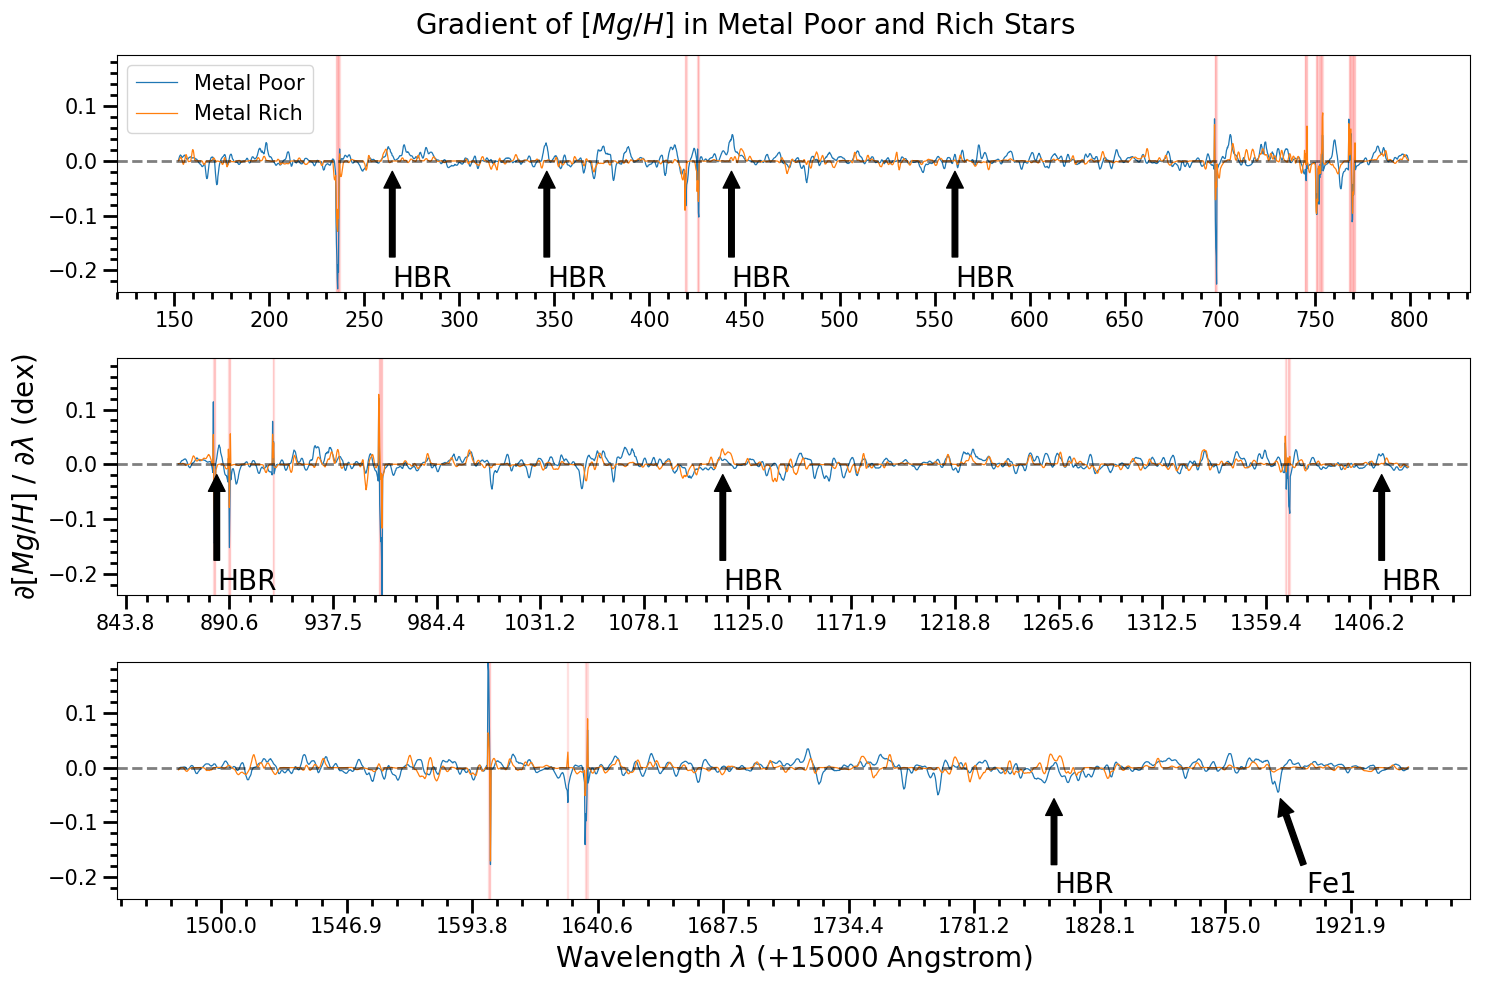

In [45]:
%matplotlib inline
import pylab as plt
import matplotlib.ticker as ticker
from astroNN.apogee.chips import wavelength_solution, chips_split
from astroNN.apogee import aspcap_mask

lambda_blue, lambda_green, lambda_red = wavelength_solution(dr=14)

lambda_blue -= 15000
lambda_green -= 15000
lambda_red -= 15000

nn_neuron = 7
target_name = '[Mg/H]'

fig = plt.figure(figsize=(15, 10), dpi=100)
metal_poor_jac_b, metal_poor_jac_g, metal_poor_jac_r = chips_split(metal_poor_jac, dr=14)
metal_rich_jac_b, metal_rich_jac_g, metal_rich_jac_r = chips_split(metal_rich_jac, dr=14)
c1_mask_b, c1_mask_g, c1_mask_r = chips_split(aspcap_mask('mg', dr=14), dr=14)

min_jacpoint = np.min([np.min(metal_poor_jac[nn_neuron]), np.min(metal_rich_jac[nn_neuron])])
max_jacpoint = np.max([np.max(metal_poor_jac[nn_neuron]), np.max(metal_rich_jac[nn_neuron])])

fig.suptitle(f'Gradient of ${target_name}$ in Metal Poor and Rich Stars', fontsize=20)
ax1 = fig.add_subplot(311)
for ll in lambda_blue[c1_mask_b[0]]:
    ax1.axvline(ll, c='r', alpha=0.1, lw=1.)
ax1.plot(lambda_blue, metal_poor_jac_b[nn_neuron], linewidth=0.9, label='Metal Poor')
ax1.plot(lambda_blue, metal_rich_jac_b[nn_neuron], linewidth=0.9, label='Metal Rich')
ax1.set_ylim((min_jacpoint, max_jacpoint))

ax2 = fig.add_subplot(312)
for ll in lambda_green[c1_mask_g[0]]:
    ax2.axvline(ll, c='r', alpha=0.1, lw=1.)
ax2.set_ylabel(r'$\partial$' + f'${target_name}$' + ' / ' + r'$\partial\lambda$ (dex)', fontsize=20)
ax2.plot(lambda_green, metal_poor_jac_g[nn_neuron], linewidth=0.9, label='Metal Poor')
ax2.plot(lambda_green, metal_rich_jac_g[nn_neuron], linewidth=0.9, label='Metal Rich')
ax2.set_ylim((min_jacpoint, max_jacpoint))

ax3 = fig.add_subplot(313)
for ll in lambda_red[c1_mask_r[0]]:
    ax3.axvline(ll, c='r', alpha=0.1, lw=1.)
ax3.plot(lambda_red, metal_poor_jac_r[nn_neuron], linewidth=0.9, label='Metal Poor')
ax3.plot(lambda_red, metal_rich_jac_r[nn_neuron], linewidth=0.9, label='Metal Rich')
ax3.set_ylim((min_jacpoint, max_jacpoint))

ax1.tick_params(labelsize=15, width=2, length=10, which='major')
ax1.tick_params(width=2, length=5, which='minor')
ax2.tick_params(labelsize=15, width=2, length=10, which='major')
ax2.tick_params(width=2, length=5, which='minor')
ax3.tick_params(labelsize=15, width=2, length=10, which='major')
ax3.tick_params(width=2, length=5, which='minor')
ax1.legend(loc='best', fontsize=15)
ax3.set_xlabel(r'Wavelength $\lambda$ (+15000 Angstrom)', fontsize=20)

ax1.axhline(0, ls='--', c='k', lw=2, alpha=0.5)
ax2.axhline(0, ls='--', c='k', lw=2, alpha=0.5)
ax3.axhline(0, ls='--', c='k', lw=2, alpha=0.5)

for HBR_blue_line in HBR_blue_lines:
    ax1.annotate('HBR', xy=(HBR_blue_line, -0.01), xytext=(HBR_blue_line, min_jacpoint + 0.01), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

for HBR_green_line in HBR_green_lines:
    ax2.annotate('HBR', xy=(HBR_green_line, -0.01), xytext=(HBR_green_line, min_jacpoint + 0.01), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

for HBR_red_line in HBR_red_lines:
    ax3.annotate('HBR', xy=(HBR_red_line, -0.05), xytext=(HBR_red_line, min_jacpoint + 0.01), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

ax3.annotate('Fe1', xy=(1895.183, -0.05), xytext=(1895.183 + 10., min_jacpoint + 0.01), 
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)
    
tick_spacing = 75
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing / 1.5))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing / 1.6))
ax3.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing / 1.6))
ax1.minorticks_on()
ax2.minorticks_on()
ax3.minorticks_on()
plt.tight_layout(rect=[0, 0.00, 1, 0.96])
plt.savefig("jac_mg_h.png")

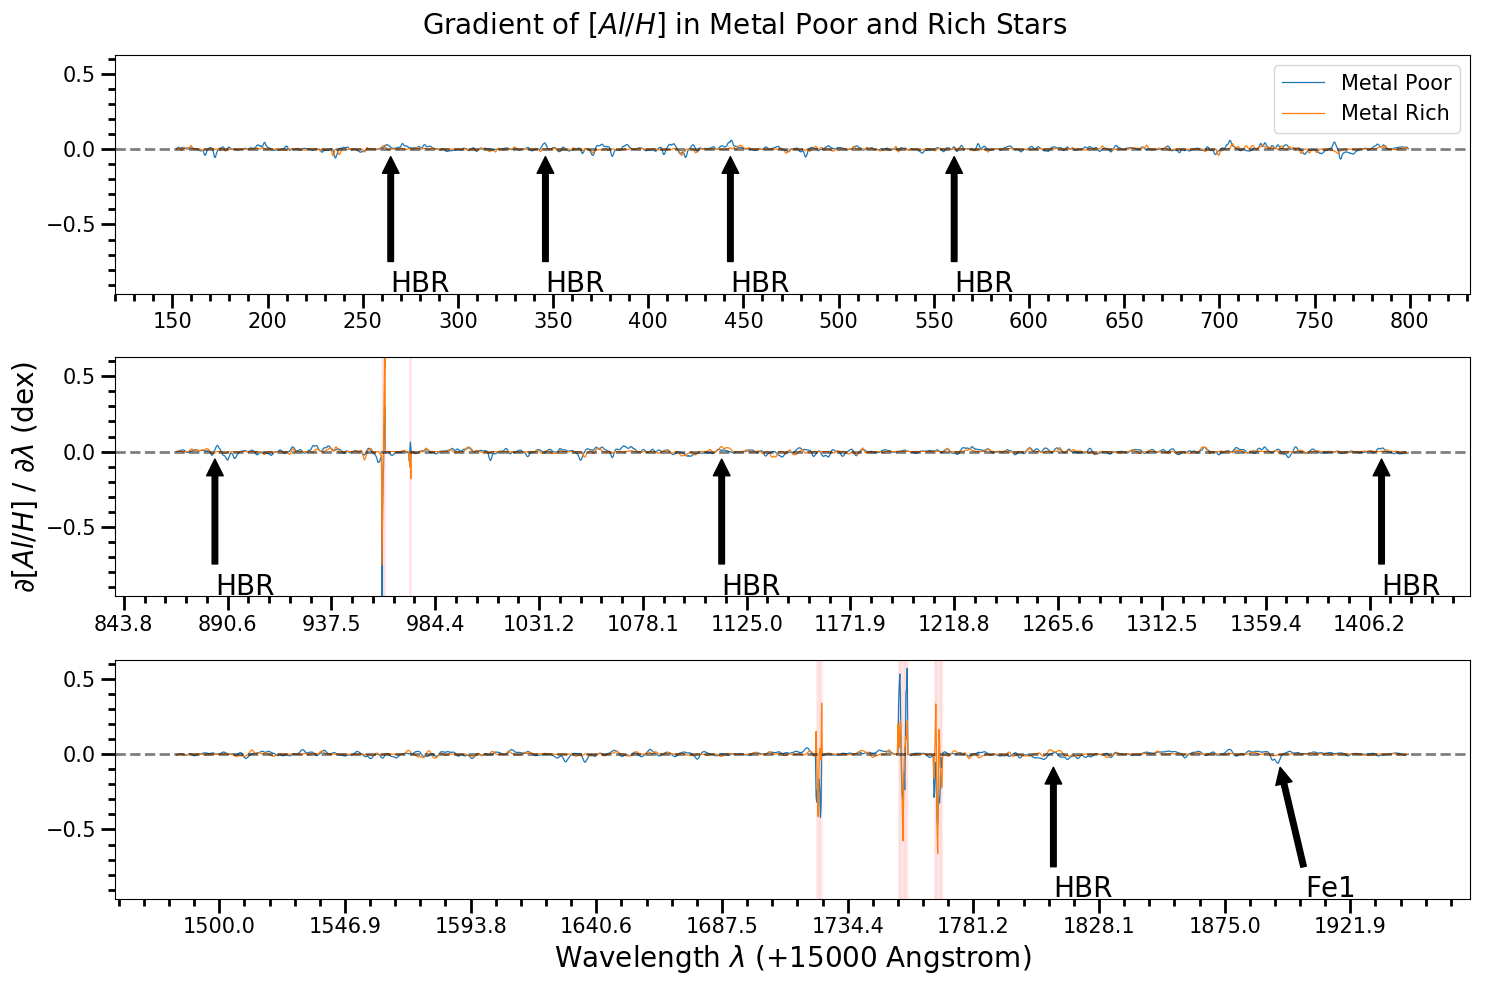

In [36]:
%matplotlib inline
import pylab as plt
import matplotlib.ticker as ticker
from astroNN.apogee.chips import wavelength_solution, chips_split
from astroNN.apogee import aspcap_mask

lambda_blue, lambda_green, lambda_red = wavelength_solution(dr=14)

lambda_blue -= 15000
lambda_green -= 15000
lambda_red -= 15000

nn_neuron = 8
target_name = '[Al/H]'

fig = plt.figure(figsize=(15, 10), dpi=100)
metal_poor_jac_b, metal_poor_jac_g, metal_poor_jac_r = chips_split(metal_poor_jac, dr=14)
metal_rich_jac_b, metal_rich_jac_g, metal_rich_jac_r = chips_split(metal_rich_jac, dr=14)
c1_mask_b, c1_mask_g, c1_mask_r = chips_split(aspcap_mask('al', dr=14), dr=14)

min_jacpoint = np.min([np.min(metal_poor_jac[nn_neuron]), np.min(metal_rich_jac[nn_neuron])])
max_jacpoint = np.max([np.max(metal_poor_jac[nn_neuron]), np.max(metal_rich_jac[nn_neuron])])

fig.suptitle(f'Gradient of ${target_name}$ in Metal Poor and Rich Stars', fontsize=20)
ax1 = fig.add_subplot(311)
for ll in lambda_blue[c1_mask_b[0]]:
    ax1.axvline(ll, c='r', alpha=0.05, lw=1.)
ax1.plot(lambda_blue, metal_poor_jac_b[nn_neuron], linewidth=0.9, label='Metal Poor')
ax1.plot(lambda_blue, metal_rich_jac_b[nn_neuron], linewidth=0.9, label='Metal Rich')
ax1.set_ylim((min_jacpoint, max_jacpoint))

ax2 = fig.add_subplot(312)
for ll in lambda_green[c1_mask_g[0]]:
    ax2.axvline(ll, c='r', alpha=0.05, lw=1.)
ax2.set_ylabel(r'$\partial$' + f'${target_name}$' + ' / ' + r'$\partial\lambda$ (dex)', fontsize=20)
ax2.plot(lambda_green, metal_poor_jac_g[nn_neuron], linewidth=0.9, label='Metal Poor')
ax2.plot(lambda_green, metal_rich_jac_g[nn_neuron], linewidth=0.9, label='Metal Rich')
ax2.set_ylim((min_jacpoint, max_jacpoint))

ax3 = fig.add_subplot(313)
for ll in lambda_red[c1_mask_r[0]]:
    ax3.axvline(ll, c='r', alpha=0.05, lw=1.)
ax3.plot(lambda_red, metal_poor_jac_r[nn_neuron], linewidth=0.9, label='Metal Poor')
ax3.plot(lambda_red, metal_rich_jac_r[nn_neuron], linewidth=0.9, label='Metal Rich')
ax3.set_ylim((min_jacpoint, max_jacpoint))

ax1.tick_params(labelsize=15, width=2, length=10, which='major')
ax1.tick_params(width=2, length=5, which='minor')
ax2.tick_params(labelsize=15, width=2, length=10, which='major')
ax2.tick_params(width=2, length=5, which='minor')
ax3.tick_params(labelsize=15, width=2, length=10, which='major')
ax3.tick_params(width=2, length=5, which='minor')
ax1.legend(loc='best', fontsize=15)
ax3.set_xlabel(r'Wavelength $\lambda$ (+15000 Angstrom)', fontsize=20)

ax1.axhline(0, ls='--', c='k', lw=2, alpha=0.5)
ax2.axhline(0, ls='--', c='k', lw=2, alpha=0.5)
ax3.axhline(0, ls='--', c='k', lw=2, alpha=0.5)

for HBR_blue_line in HBR_blue_lines:
    ax1.annotate('HBR', xy=(HBR_blue_line, -0.01), xytext=(HBR_blue_line, min_jacpoint + 0.01), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

for HBR_green_line in HBR_green_lines:
    ax2.annotate('HBR', xy=(HBR_green_line, -0.01), xytext=(HBR_green_line, min_jacpoint + 0.01), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

for HBR_red_line in HBR_red_lines:
    ax3.annotate('HBR', xy=(HBR_red_line, -0.05), xytext=(HBR_red_line, min_jacpoint + 0.01), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

ax3.annotate('Fe1', xy=(1895.183, -0.05), xytext=(1895.183 + 10., min_jacpoint + 0.01), 
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)
    
tick_spacing = 75
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing / 1.5))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing / 1.6))
ax3.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing / 1.6))
ax1.minorticks_on()
ax2.minorticks_on()
ax3.minorticks_on()
plt.tight_layout(rect=[0, 0.00, 1, 0.96])

In [18]:
hot_jac = bcnn.jacobian(x[pred[:,0]<4150], mean_output=True, denormalize=True)
cool_jac = bcnn.jacobian(x[pred[:,0]>5350], mean_output=True, denormalize=True)

Finished all gradient calculation, 50.71 seconds elapsed
Finished all gradient calculation, 29.64 seconds elapsed


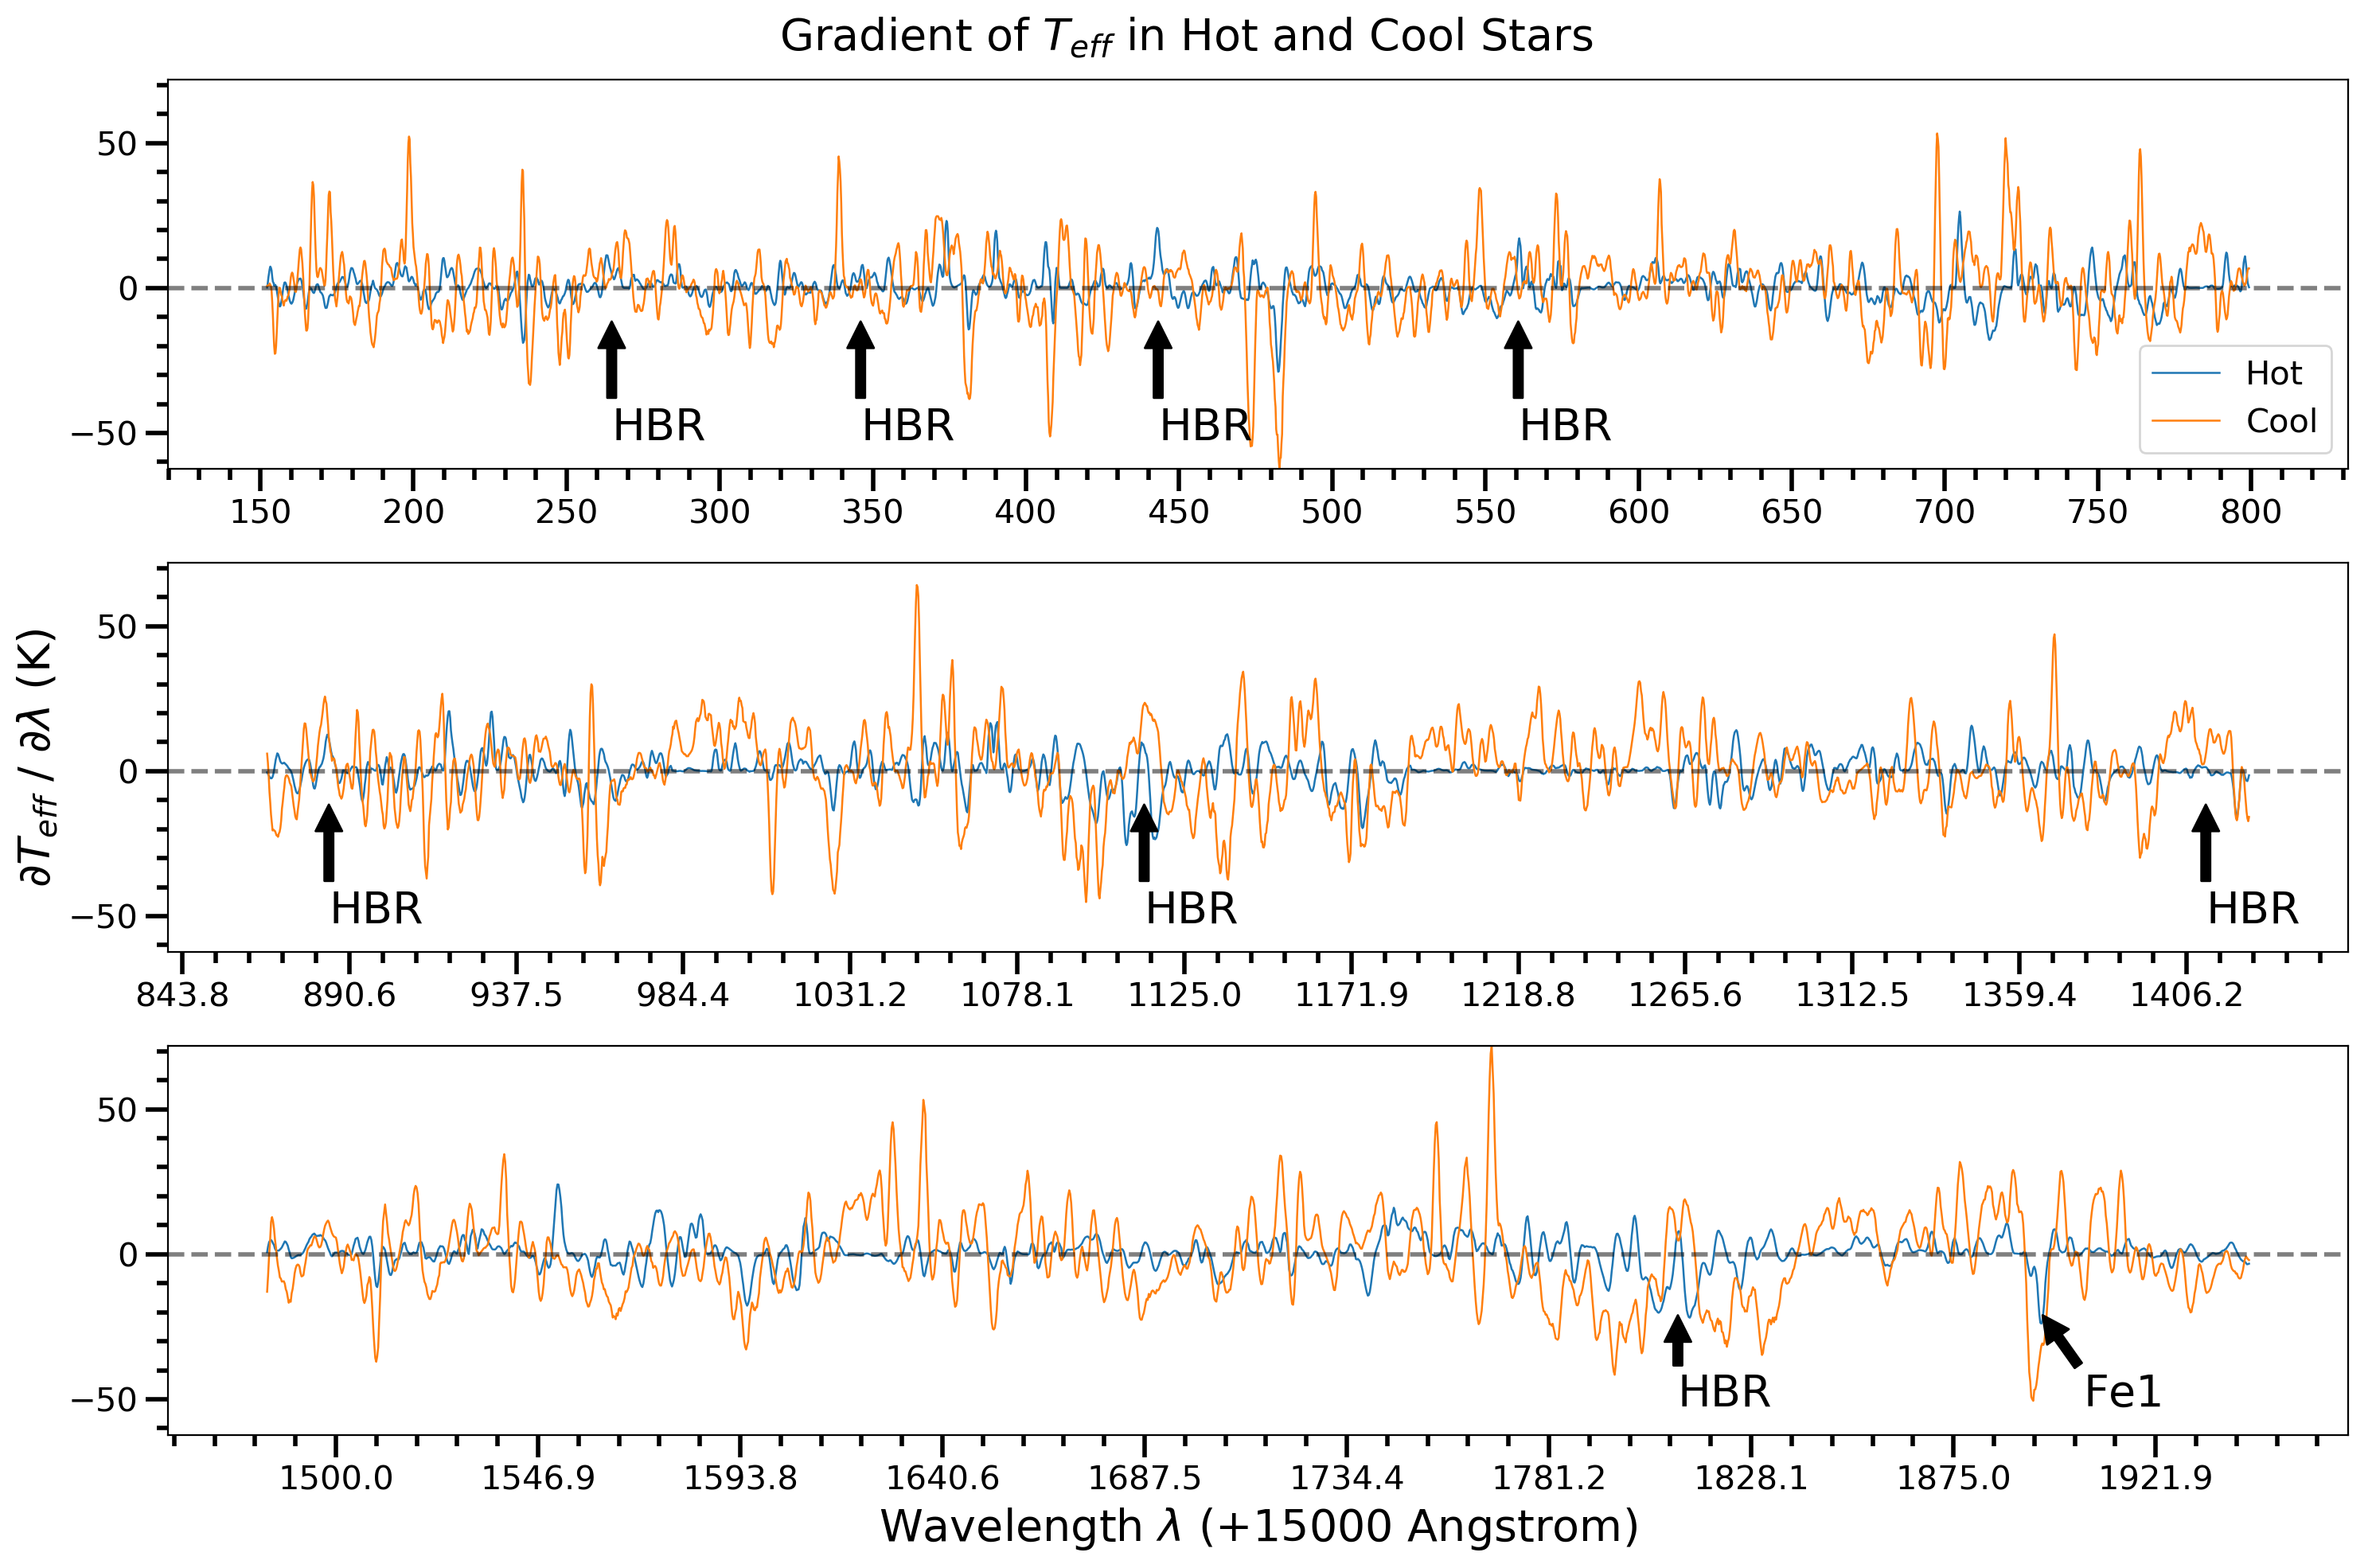

In [19]:
%matplotlib inline
import pylab as plt
import matplotlib.ticker as ticker
from astroNN.apogee.chips import wavelength_solution, chips_split

lambda_blue, lambda_green, lambda_red = wavelength_solution(dr=14)

lambda_blue -= 15000
lambda_green -= 15000
lambda_red -= 15000

nn_neuron = 0
target_name = 'T_{eff}'

fig = plt.figure(figsize=(15, 10), dpi=200)
hot_jac_b, hot_jac_g, hot_jacc_r = chips_split(hot_jac, dr=14)
cool_jac_b, cool_jac_g, cool_jac_r = chips_split(cool_jac, dr=14)

min_jacpoint = np.min([np.min(hot_jac[nn_neuron]), np.min(cool_jac[nn_neuron])])
max_jacpoint = np.max([np.max(hot_jac[nn_neuron]), np.max(cool_jac[nn_neuron])])

fig.suptitle(f'Gradient of ${target_name}$ in Hot and Cool Stars', fontsize=20)
ax1 = fig.add_subplot(311)
ax1.plot(lambda_blue, hot_jac_b[nn_neuron], linewidth=0.9, label='Hot')
ax1.plot(lambda_blue, cool_jac_b[nn_neuron], linewidth=0.9, label='Cool')
ax1.set_ylim((min_jacpoint, max_jacpoint))

ax2 = fig.add_subplot(312)
ax2.set_ylabel(r'$\partial$' + f'${target_name}$' + ' / ' + r'$\partial\lambda$ (K)', fontsize=20)
ax2.plot(lambda_green, hot_jac_g[nn_neuron], linewidth=0.9, label='Hot')
ax2.plot(lambda_green, cool_jac_g[nn_neuron], linewidth=0.9, label='Cool')
ax2.set_ylim((min_jacpoint, max_jacpoint))

ax3 = fig.add_subplot(313)
ax3.plot(lambda_red, hot_jacc_r[nn_neuron], linewidth=0.9, label='Hot')
ax3.plot(lambda_red, cool_jac_r[nn_neuron], linewidth=0.9, label='Cool')
ax3.set_ylim((min_jacpoint, max_jacpoint))

ax1.tick_params(labelsize=15, width=2, length=10, which='major')
ax1.tick_params(width=2, length=5, which='minor')
ax2.tick_params(labelsize=15, width=2, length=10, which='major')
ax2.tick_params(width=2, length=5, which='minor')
ax3.tick_params(labelsize=15, width=2, length=10, which='major')
ax3.tick_params(width=2, length=5, which='minor')
ax1.legend(loc='best', fontsize=15)
ax3.set_xlabel(r'Wavelength $\lambda$ (+15000 Angstrom)', fontsize=20)

ax1.axhline(0, ls='--', c='k', lw=2, alpha=0.5)
ax2.axhline(0, ls='--', c='k', lw=2, alpha=0.5)
ax3.axhline(0, ls='--', c='k', lw=2, alpha=0.5)

for HBR_blue_line in HBR_blue_lines:
    ax1.annotate('HBR', xy=(HBR_blue_line, -10), xytext=(HBR_blue_line, min_jacpoint + 10), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

for HBR_green_line in HBR_green_lines:
    ax2.annotate('HBR', xy=(HBR_green_line, -10), xytext=(HBR_green_line, min_jacpoint + 10), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

for HBR_red_line in HBR_red_lines:
    ax3.annotate('HBR', xy=(HBR_red_line, -20), xytext=(HBR_red_line, min_jacpoint + 10), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

ax3.annotate('Fe1', xy=(1895.183, -20), xytext=(1895.183 + 10., min_jacpoint + 10), 
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)
    
tick_spacing = 75
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing / 1.5))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing / 1.6))
ax3.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing / 1.6))
ax1.minorticks_on()
ax2.minorticks_on()
ax3.minorticks_on()
plt.tight_layout(rect=[0, 0.00, 1, 0.96])

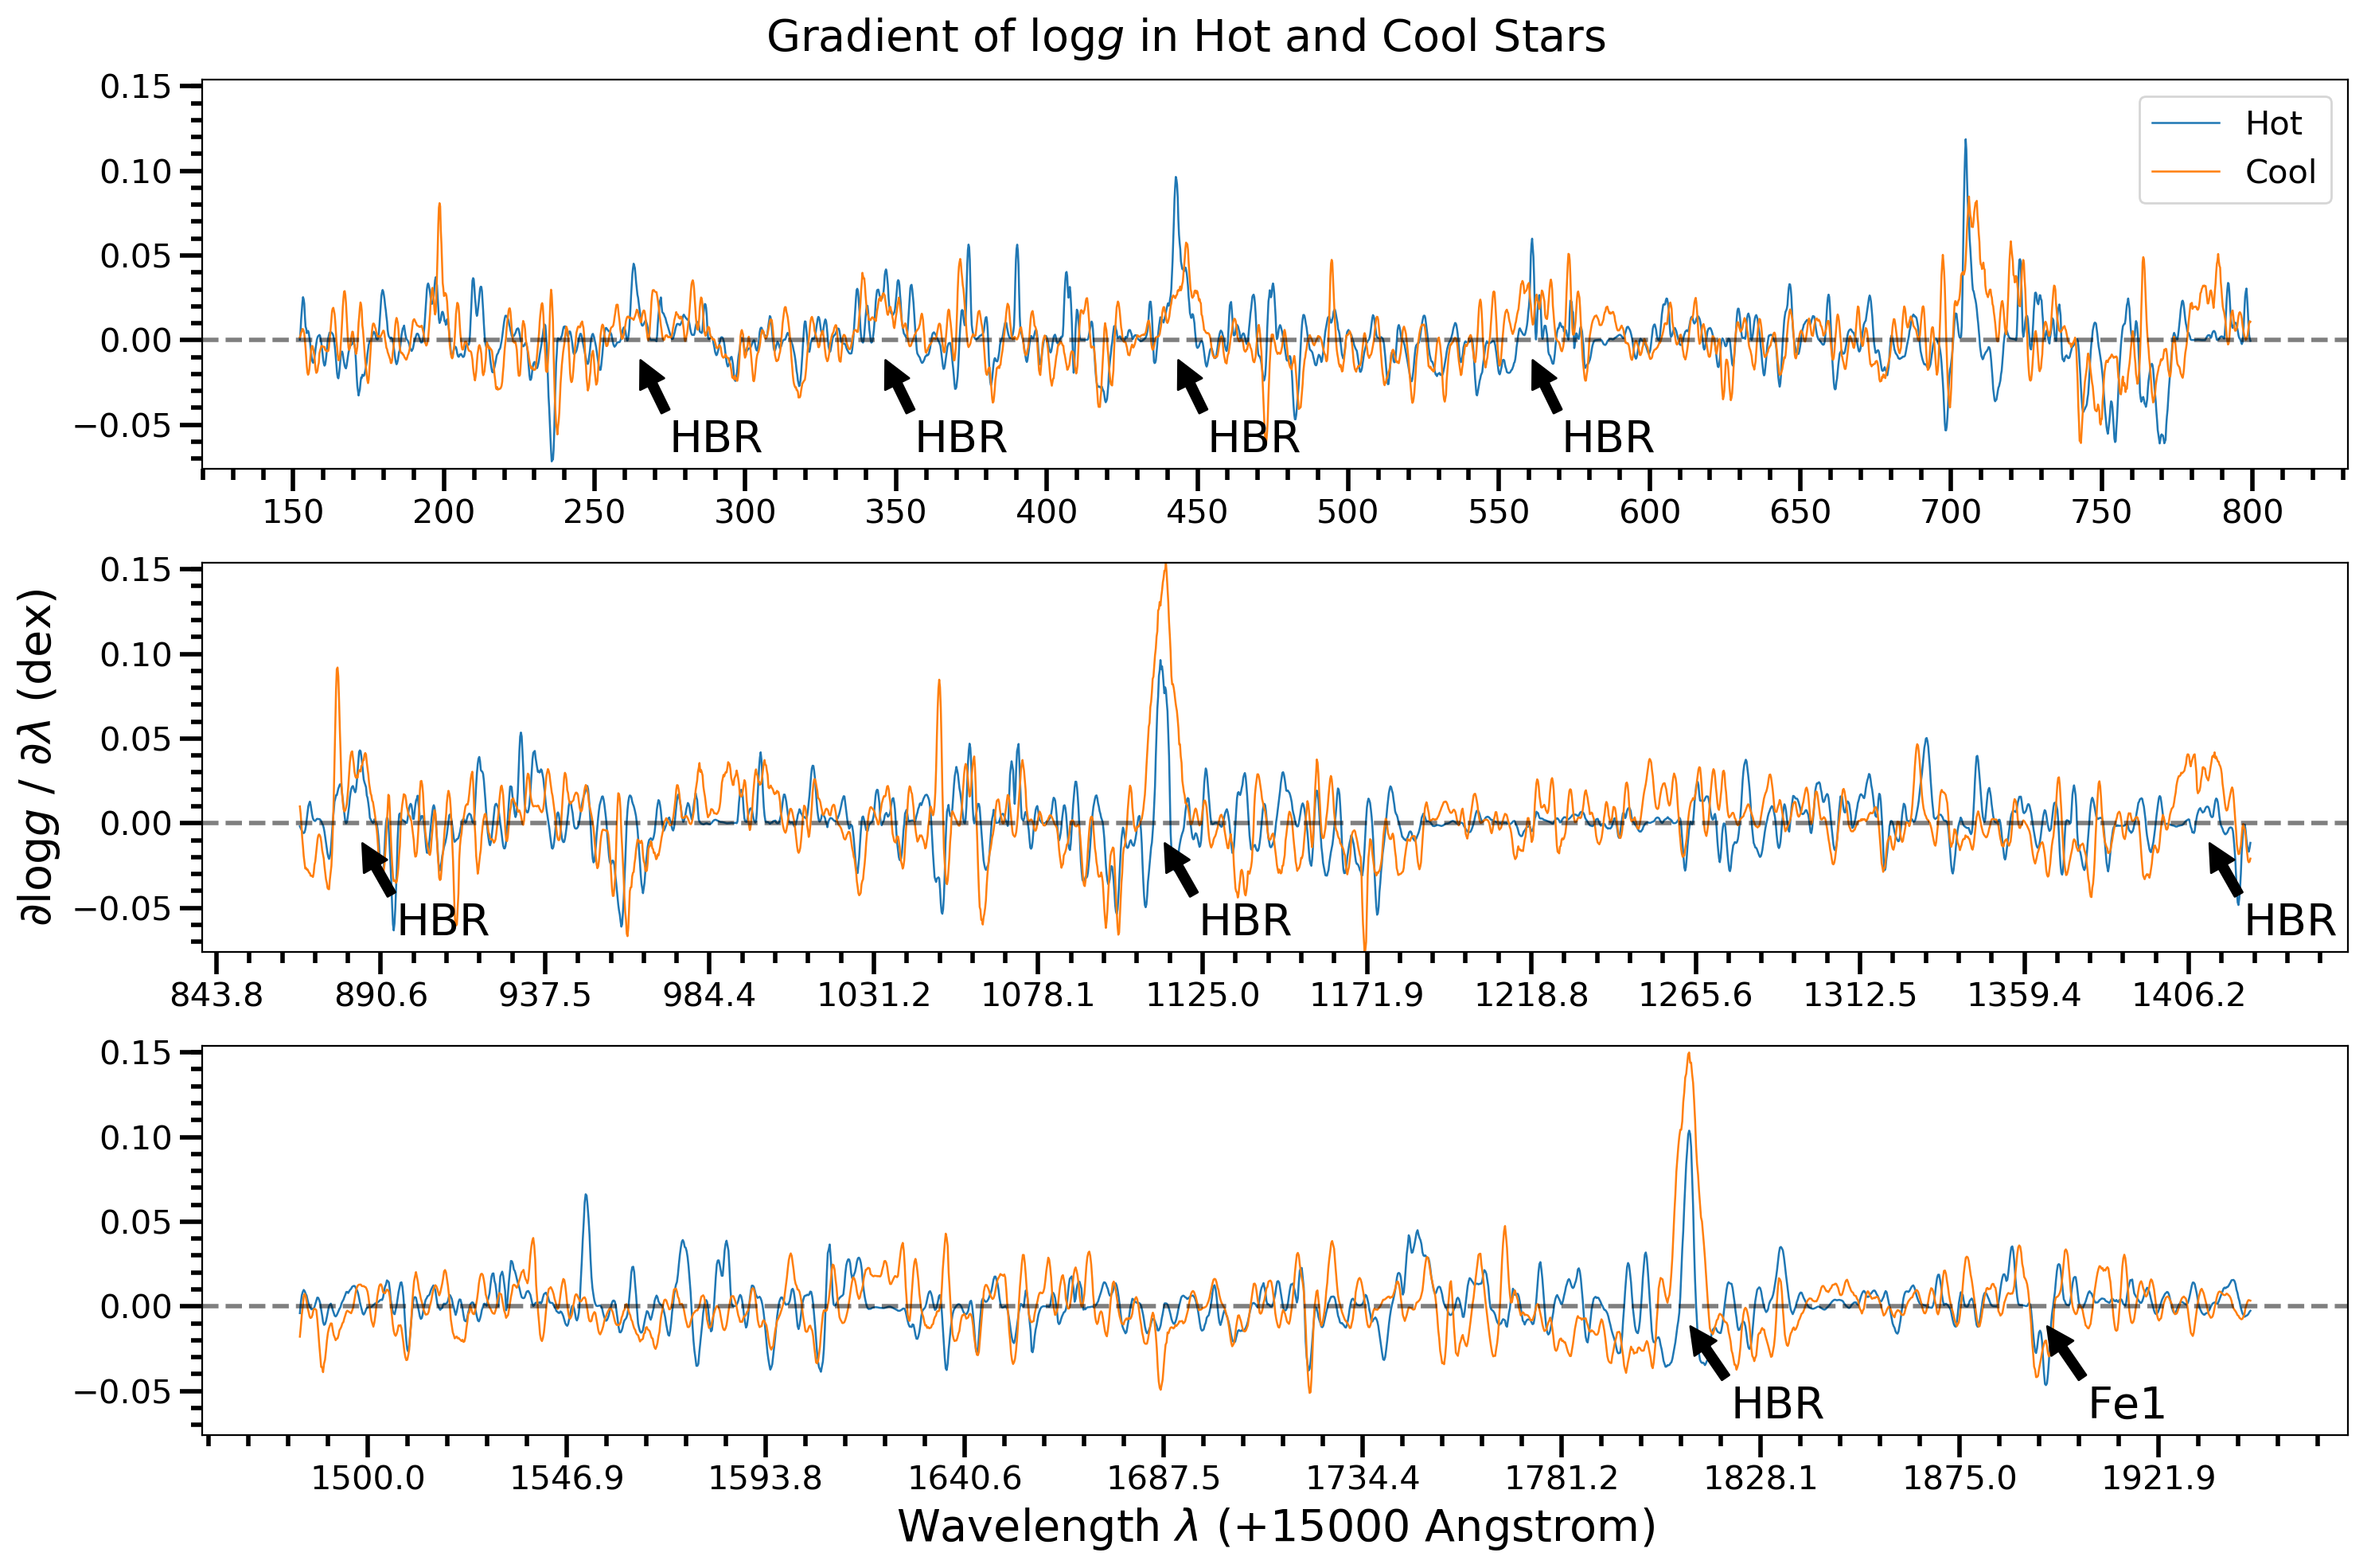

In [20]:
%matplotlib inline
import pylab as plt
import matplotlib.ticker as ticker
from astroNN.apogee.chips import wavelength_solution, chips_split

lambda_blue, lambda_green, lambda_red = wavelength_solution(dr=14)

lambda_blue -= 15000
lambda_green -= 15000
lambda_red -= 15000

nn_neuron = 1
target_name = '\log{g}'

fig = plt.figure(figsize=(15, 10), dpi=200)
hot_jac_b, hot_jac_g, hot_jacc_r = chips_split(hot_jac, dr=14)
cool_jac_b, cool_jac_g, cool_jac_r = chips_split(cool_jac, dr=14)

min_jacpoint = np.min([np.min(cool_jac[nn_neuron]), np.min(hot_jac[nn_neuron])])
max_jacpoint = np.max([np.max(cool_jac[nn_neuron]), np.max(hot_jac[nn_neuron])])

fig.suptitle(f'Gradient of ${target_name}$ in Hot and Cool Stars', fontsize=20)
ax1 = fig.add_subplot(311)
ax1.plot(lambda_blue, hot_jac_b[nn_neuron], linewidth=0.9, label='Hot')
ax1.plot(lambda_blue, cool_jac_b[nn_neuron], linewidth=0.9, label='Cool')
ax1.set_ylim((min_jacpoint, max_jacpoint))

ax2 = fig.add_subplot(312)
ax2.set_ylabel(r'$\partial$' + f'${target_name}$' + ' / ' + r'$\partial\lambda$ (dex)', fontsize=20)
ax2.plot(lambda_green, hot_jac_g[nn_neuron], linewidth=0.9, label='Hot')
ax2.plot(lambda_green, cool_jac_g[nn_neuron], linewidth=0.9, label='Cool')
ax2.set_ylim((min_jacpoint, max_jacpoint))

ax3 = fig.add_subplot(313)
ax3.plot(lambda_red, hot_jacc_r[nn_neuron], linewidth=0.9, label='Hot')
ax3.plot(lambda_red, cool_jac_r[nn_neuron], linewidth=0.9, label='Cool')
ax3.set_ylim((min_jacpoint, max_jacpoint))

ax1.tick_params(labelsize=15, width=2, length=10, which='major')
ax1.tick_params(width=2, length=5, which='minor')
ax2.tick_params(labelsize=15, width=2, length=10, which='major')
ax2.tick_params(width=2, length=5, which='minor')
ax3.tick_params(labelsize=15, width=2, length=10, which='major')
ax3.tick_params(width=2, length=5, which='minor')
ax1.legend(loc='best', fontsize=15)
ax3.set_xlabel(r'Wavelength $\lambda$ (+15000 Angstrom)', fontsize=20)

ax1.axhline(0, ls='--', c='k', lw=2, alpha=0.5)
ax2.axhline(0, ls='--', c='k', lw=2, alpha=0.5)
ax3.axhline(0, ls='--', c='k', lw=2, alpha=0.5)

for HBR_blue_line in HBR_blue_lines:
    ax1.annotate('HBR', xy=(HBR_blue_line, -0.01), xytext=(HBR_blue_line + 10., min_jacpoint + 0.01), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

for HBR_green_line in HBR_green_lines:
    ax2.annotate('HBR', xy=(HBR_green_line, -0.01), xytext=(HBR_green_line + 10., min_jacpoint + 0.01), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

for HBR_red_line in HBR_red_lines:
    ax3.annotate('HBR', xy=(HBR_red_line, -0.01), xytext=(HBR_red_line +10., min_jacpoint + 0.01), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

ax3.annotate('Fe1', xy=(1895.183, -0.01), xytext=(1895.183 + 10., min_jacpoint + 0.01), 
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)
    
tick_spacing = 75
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing / 1.5))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing / 1.6))
ax3.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing / 1.6))
ax1.minorticks_on()
ax2.minorticks_on()
ax3.minorticks_on()
plt.tight_layout(rect=[0, 0.00, 1, 0.96])